# 🎵 Audio Signal Processing: Framing, Windowing & Spectral Leakage

**Reference:** Valerio Velardo's "Audio Signal Processing for Machine Learning" (parallel)

This notebook provides a comprehensive deep-dive into the critical concepts of audio signal processing for machine learning:

1. **The Core Problem**: Non-Stationary Signals
2. **The Solution**: Framing
3. **The Artifact**: Spectral Leakage
4. **The Fix**: Windowing
5. **Hop Length and Overlap**
6. **Implementation in Python (Librosa)**

---

## 📚 Reference Image: Complete Overview

Below is the complete reference material covering all concepts we'll explore in detail:

![Audio Signal Processing Overview](attachment:audio_signal_processing_overview.png)

*Note: This image contains the foundational concepts we'll implement and demonstrate throughout this notebook.*

**To attach your image**: In Jupyter, go to Edit → Insert Image, or drag and drop your image file into this markdown cell.

---

## 🔧 Setup and Imports

In [1]:
# Install required libraries (uncomment if needed)
# !pip install librosa numpy matplotlib scipy IPython

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import librosa
import librosa.display
from scipy import signal
from scipy.fft import fft, fftfreq
from IPython.display import HTML, Image, display
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print(f"Librosa version: {librosa.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
Librosa version: 0.11.0
NumPy version: 2.0.2


---

## 1. 🌊 The Core Problem: Non-Stationary Signals

### What Does "Non-Stationary" Mean?

To understand why we need special processing for audio, we must first distinguish between two types of signals:

#### **Stationary Signals**
- Properties (frequency, amplitude) **remain constant** over time
- Example: A pure sine wave at 440 Hz that never changes
- The Fourier Transform (FT) works perfectly on these

#### **Non-Stationary Signals** ⚠️
- Properties **change constantly** over time
- Example: Speech, music, real-world audio
- The standard Fourier Transform **loses time information**

### The Problem with Standard Fourier Transform

The Fourier Transform (FT) assumes the signal is **infinite and unchanging**. When you apply FT to an entire song:
- You get the **average frequency content** of the whole song
- You **lose all time information** (when did each note occur?)
- You can't distinguish between a C note at second 1 vs. second 10

### Real-World Example

Imagine analyzing a sentence: "Hello, how are you?"
- **Standard FT**: Tells you the average pitch across the entire sentence
- **What we need**: The pitch of each phoneme at each moment in time

### The Solution Preview

We need to:
1. **Break the signal into small chunks** (frames)
2. **Analyze each chunk separately** (Short-Time Fourier Transform - STFT)
3. **Preserve time information** while getting frequency information

Let's demonstrate this problem visually:

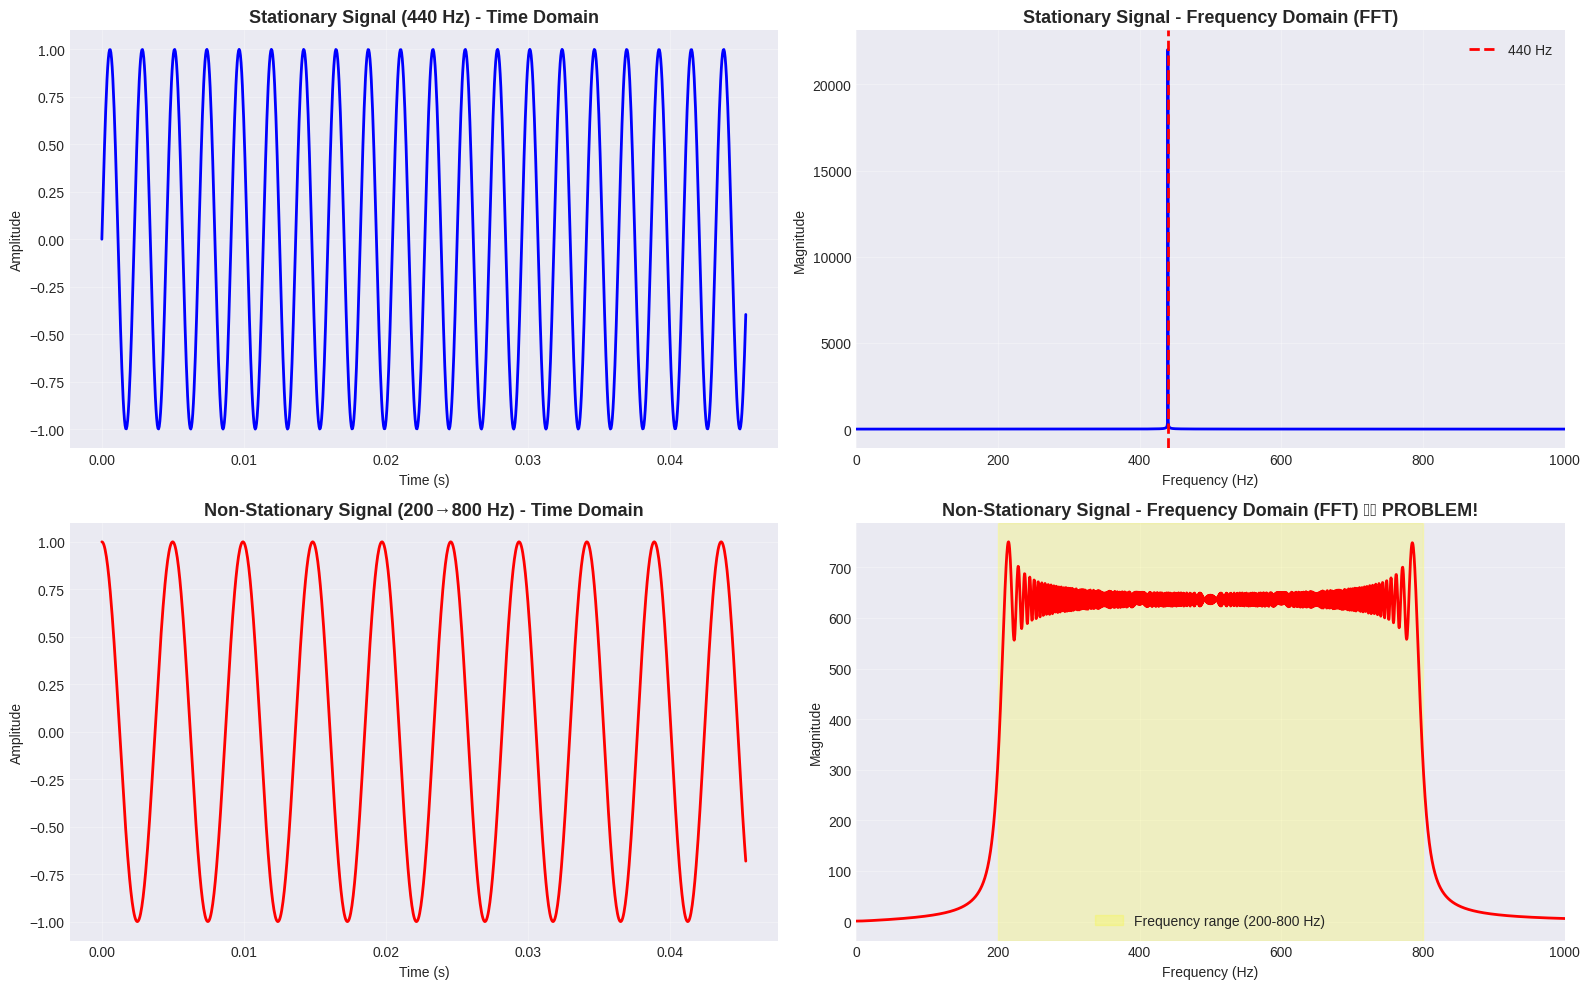


🔍 Key Observations:

📘 STATIONARY SIGNAL (Top):
   • Time domain: Regular, unchanging sine wave
   • Frequency domain: Single sharp peak at 440 Hz ✓
   • FFT works perfectly - we know exactly what frequency is present

📕 NON-STATIONARY SIGNAL (Bottom):
   • Time domain: Frequency increases over time (visible as tighter waves)
   • Frequency domain: Smeared across 200-800 Hz ✗
   • FFT shows ALL frequencies but NOT WHEN they occurred!
   • We lost time information - this is the core problem!


In [2]:
# Create a non-stationary signal: frequency changes over time
sr = 22050  # Sample rate
duration = 2  # seconds
t = np.linspace(0, duration, int(sr * duration))

# Create a signal where frequency increases over time (chirp)
# Starts at 200 Hz, ends at 800 Hz
f_start = 200
f_end = 800
chirp_signal = signal.chirp(t, f_start, duration, f_end, method='linear')

# Also create a stationary signal for comparison
stationary_signal = np.sin(2 * np.pi * 440 * t)  # Pure 440 Hz

# Plot both signals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Stationary signal - time domain
axes[0, 0].plot(t[:1000], stationary_signal[:1000], linewidth=2, color='blue')
axes[0, 0].set_title('Stationary Signal (440 Hz) - Time Domain', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

# Stationary signal - frequency domain
fft_stationary = np.abs(fft(stationary_signal))
freqs_stationary = fftfreq(len(stationary_signal), 1/sr)
axes[0, 1].plot(freqs_stationary[:len(freqs_stationary)//2], 
                fft_stationary[:len(fft_stationary)//2], linewidth=2, color='blue')
axes[0, 1].set_title('Stationary Signal - Frequency Domain (FFT)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Magnitude')
axes[0, 1].set_xlim(0, 1000)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=440, color='red', linestyle='--', linewidth=2, label='440 Hz')
axes[0, 1].legend()

# Non-stationary signal - time domain
axes[1, 0].plot(t[:1000], chirp_signal[:1000], linewidth=2, color='red')
axes[1, 0].set_title('Non-Stationary Signal (200→800 Hz) - Time Domain', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)

# Non-stationary signal - frequency domain
fft_chirp = np.abs(fft(chirp_signal))
freqs_chirp = fftfreq(len(chirp_signal), 1/sr)
axes[1, 1].plot(freqs_chirp[:len(freqs_chirp)//2], 
                fft_chirp[:len(fft_chirp)//2], linewidth=2, color='red')
axes[1, 1].set_title('Non-Stationary Signal - Frequency Domain (FFT) ⚠️ PROBLEM!', 
                     fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_xlim(0, 1000)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvspan(200, 800, alpha=0.2, color='yellow', label='Frequency range (200-800 Hz)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n🔍 Key Observations:")
print("\n📘 STATIONARY SIGNAL (Top):")
print("   • Time domain: Regular, unchanging sine wave")
print("   • Frequency domain: Single sharp peak at 440 Hz ✓")
print("   • FFT works perfectly - we know exactly what frequency is present")

print("\n📕 NON-STATIONARY SIGNAL (Bottom):")
print("   • Time domain: Frequency increases over time (visible as tighter waves)")
print("   • Frequency domain: Smeared across 200-800 Hz ✗")
print("   • FFT shows ALL frequencies but NOT WHEN they occurred!")
print("   • We lost time information - this is the core problem!")

### 🎯 The Core Issue Summarized

| Aspect | Standard FFT | What We Need |
|--------|-------------|-------------|
| **Input** | Entire signal | Small chunks (frames) |
| **Output** | Average frequency content | Frequency content **at each time** |
| **Time Info** | ❌ Lost | ✅ Preserved |
| **Use Case** | Stationary signals | Real audio (non-stationary) |

**Solution**: Short-Time Fourier Transform (STFT) = Apply FFT to small frames!

---

## 2. 🔲 The Solution: Framing

### What is Framing?

**Framing** is the process of breaking a long audio signal into short, overlapping segments called **frames**.

### Why Frame?

1. **Preserve Time Information**: Each frame represents a specific moment in time
2. **Local Stationarity**: Within a short frame (~20-50ms), audio is approximately stationary
3. **Enable STFT**: We can apply FFT to each frame separately

### Key Parameters

#### **Frame Size (K)** - Number of samples per frame

The duration of each frame in seconds is:

$$d_f = \frac{1}{s_r} \cdot K = \frac{K}{s_r}$$

Where:
- $d_f$ = Frame duration (seconds)
- $s_r$ = Sample rate (Hz) - typically 22,050 or 44,100
- $K$ = Frame size (number of samples)

#### **Typical Values**

| Sample Rate | Frame Size (K) | Duration ($d_f$) | Use Case |
|-------------|----------------|------------------|----------|
| 22,050 Hz | 512 | ~23 ms | Fast, less detail |
| 22,050 Hz | 1024 | ~46 ms | **Standard** (Human Hearing) |
| 22,050 Hz | 2048 | ~93 ms | High detail |
| 44,100 Hz | 2048 | ~46 ms | CD quality |

### The Trade-off

- **Larger frames**: Better frequency resolution, worse time resolution
- **Smaller frames**: Better time resolution, worse frequency resolution

This is the **Uncertainty Principle** in signal processing!

Let's visualize framing:

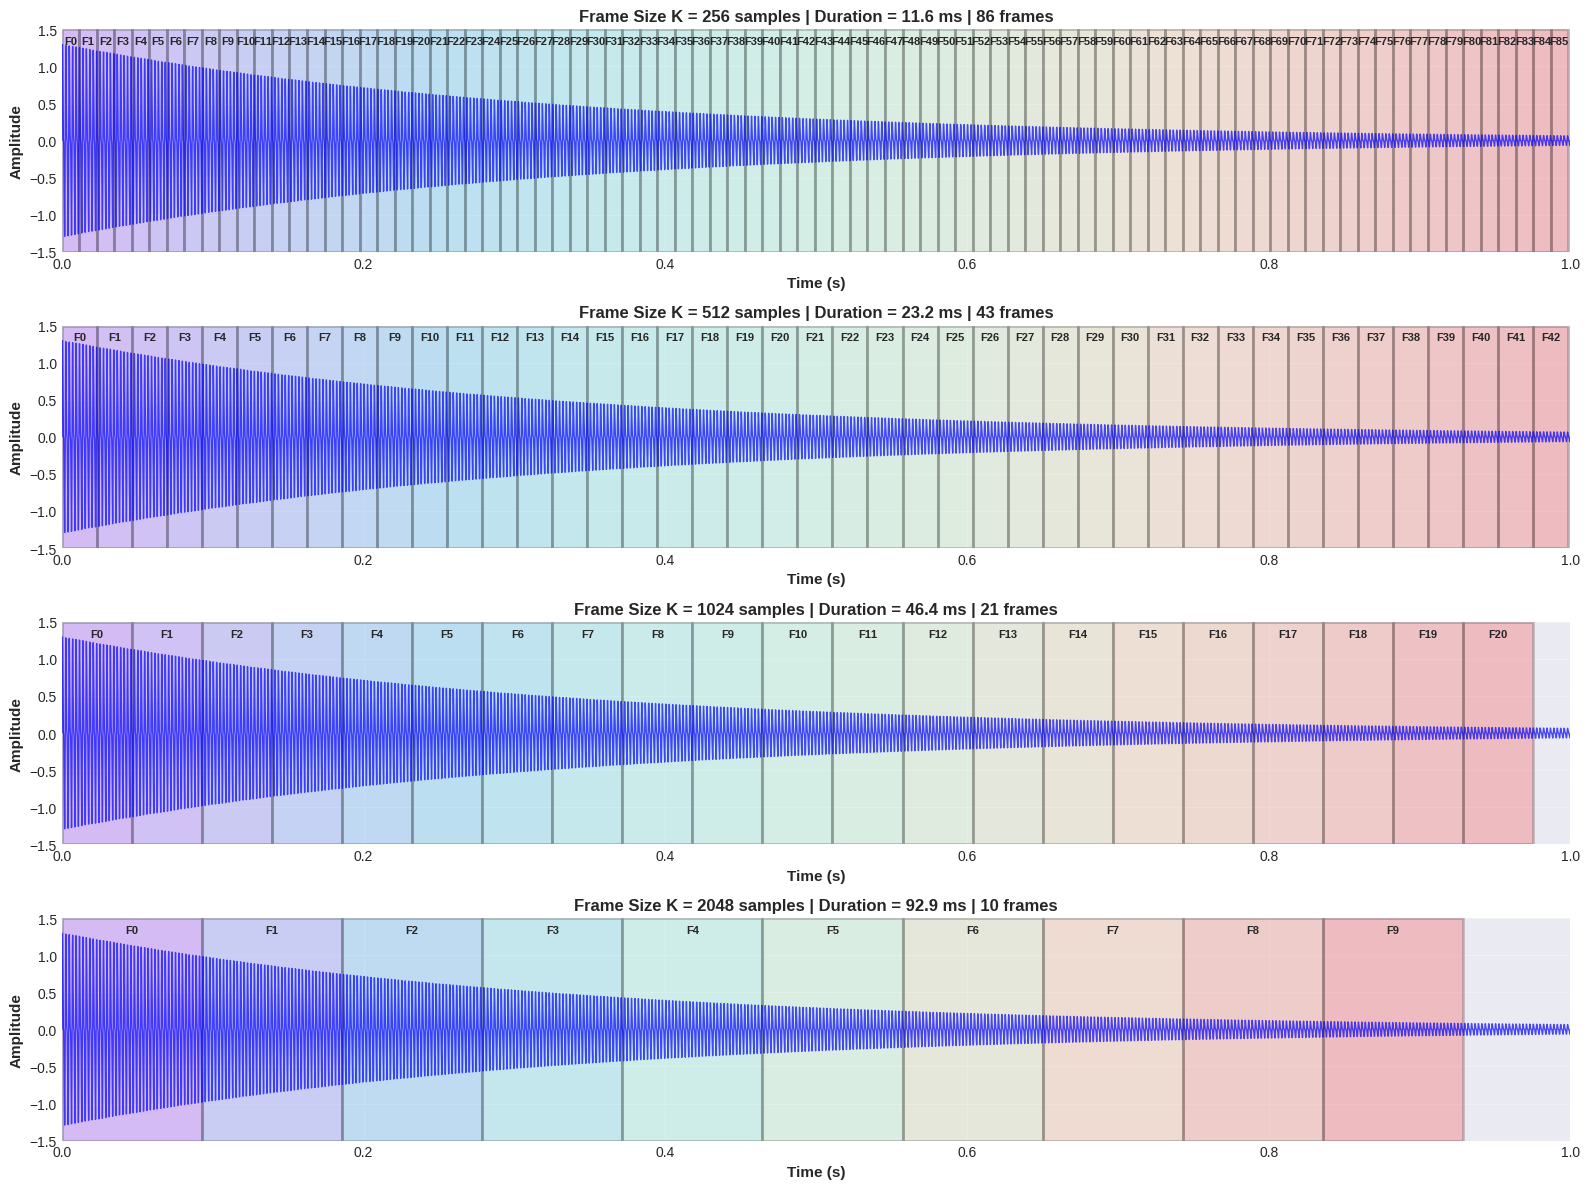


📊 Frame Size Analysis:

Formula: d_f = K / s_r
Sample Rate (s_r): 22050 Hz

K =  256 samples → d_f =  11.6 ms → 86 frames
K =  512 samples → d_f =  23.2 ms → 43 frames
K = 1024 samples → d_f =  46.4 ms → 21 frames
K = 2048 samples → d_f =  92.9 ms → 10 frames

🎯 Key Insight:
   • Smaller K → More frames → Better time resolution
   • Larger K → Fewer frames → Better frequency resolution
   • Each colored box represents one frame that will be analyzed separately


In [3]:
# Create a sample audio signal
sr = 22050
duration = 1.0
t = np.linspace(0, duration, int(sr * duration))

# Create a signal with changing frequency
signal_demo = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 880 * t)

# Add amplitude envelope
envelope = np.exp(-3 * t)
signal_demo = signal_demo * envelope

# Define different frame sizes
frame_sizes = [256, 512, 1024, 2048]

fig, axes = plt.subplots(len(frame_sizes), 1, figsize=(16, 12))

for idx, frame_size in enumerate(frame_sizes):
    ax = axes[idx]
    
    # Calculate frame duration
    frame_duration = frame_size / sr
    
    # Plot the signal
    ax.plot(t, signal_demo, linewidth=1, color='blue', alpha=0.7)
    
    # Draw frames (non-overlapping for visualization)
    num_frames = int(len(signal_demo) / frame_size)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_frames))
    
    for i in range(num_frames):
        start_sample = i * frame_size
        end_sample = start_sample + frame_size
        start_time = start_sample / sr
        end_time = end_sample / sr
        
        # Draw rectangle for each frame
        rect = Rectangle((start_time, -1.5), end_time - start_time, 3, 
                        alpha=0.2, facecolor=colors[i], edgecolor='black', linewidth=2)
        ax.add_patch(rect)
        
        # Add frame number
        ax.text(start_time + (end_time - start_time)/2, 1.3, f'F{i}', 
               ha='center', fontsize=8, fontweight='bold')
    
    ax.set_xlim(0, duration)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
    ax.set_title(f'Frame Size K = {frame_size} samples | Duration = {frame_duration*1000:.1f} ms | {num_frames} frames', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Frame Size Analysis:")
print("\nFormula: d_f = K / s_r")
print(f"Sample Rate (s_r): {sr} Hz\n")

for frame_size in frame_sizes:
    frame_duration = frame_size / sr
    num_frames = int(len(signal_demo) / frame_size)
    print(f"K = {frame_size:4d} samples → d_f = {frame_duration*1000:5.1f} ms → {num_frames:2d} frames")

print("\n🎯 Key Insight:")
print("   • Smaller K → More frames → Better time resolution")
print("   • Larger K → Fewer frames → Better frequency resolution")
print("   • Each colored box represents one frame that will be analyzed separately")

---

## 3. ⚠️ The Artifact: Spectral Leakage

### What is Spectral Leakage?

When we extract a frame from a continuous signal, we're essentially **multiplying the signal by a rectangular window**:

$$\text{Frame} = \text{Signal} \times \text{Rectangular Window}$$

Where the rectangular window is:
- 1 inside the frame
- 0 outside the frame

### The Problem

This creates **discontinuities** at the frame edges (sudden jumps from signal to zero). In the frequency domain, these discontinuities appear as:

1. **"Fake" frequencies** that weren't in the original signal
2. **Energy spreading** from the true frequency to neighboring frequencies
3. **Reduced frequency resolution**

### Why Does This Happen?

**Mathematical Explanation**:
- Multiplication in time domain = Convolution in frequency domain
- Rectangular window has a sinc function in frequency domain
- Sinc function has side lobes that "leak" energy to other frequencies

### Visual Analogy

Imagine cutting a smooth sine wave with scissors:
- The cut creates sharp edges
- Sharp edges = high-frequency components
- These high frequencies weren't in the original signal!

Let's demonstrate spectral leakage:

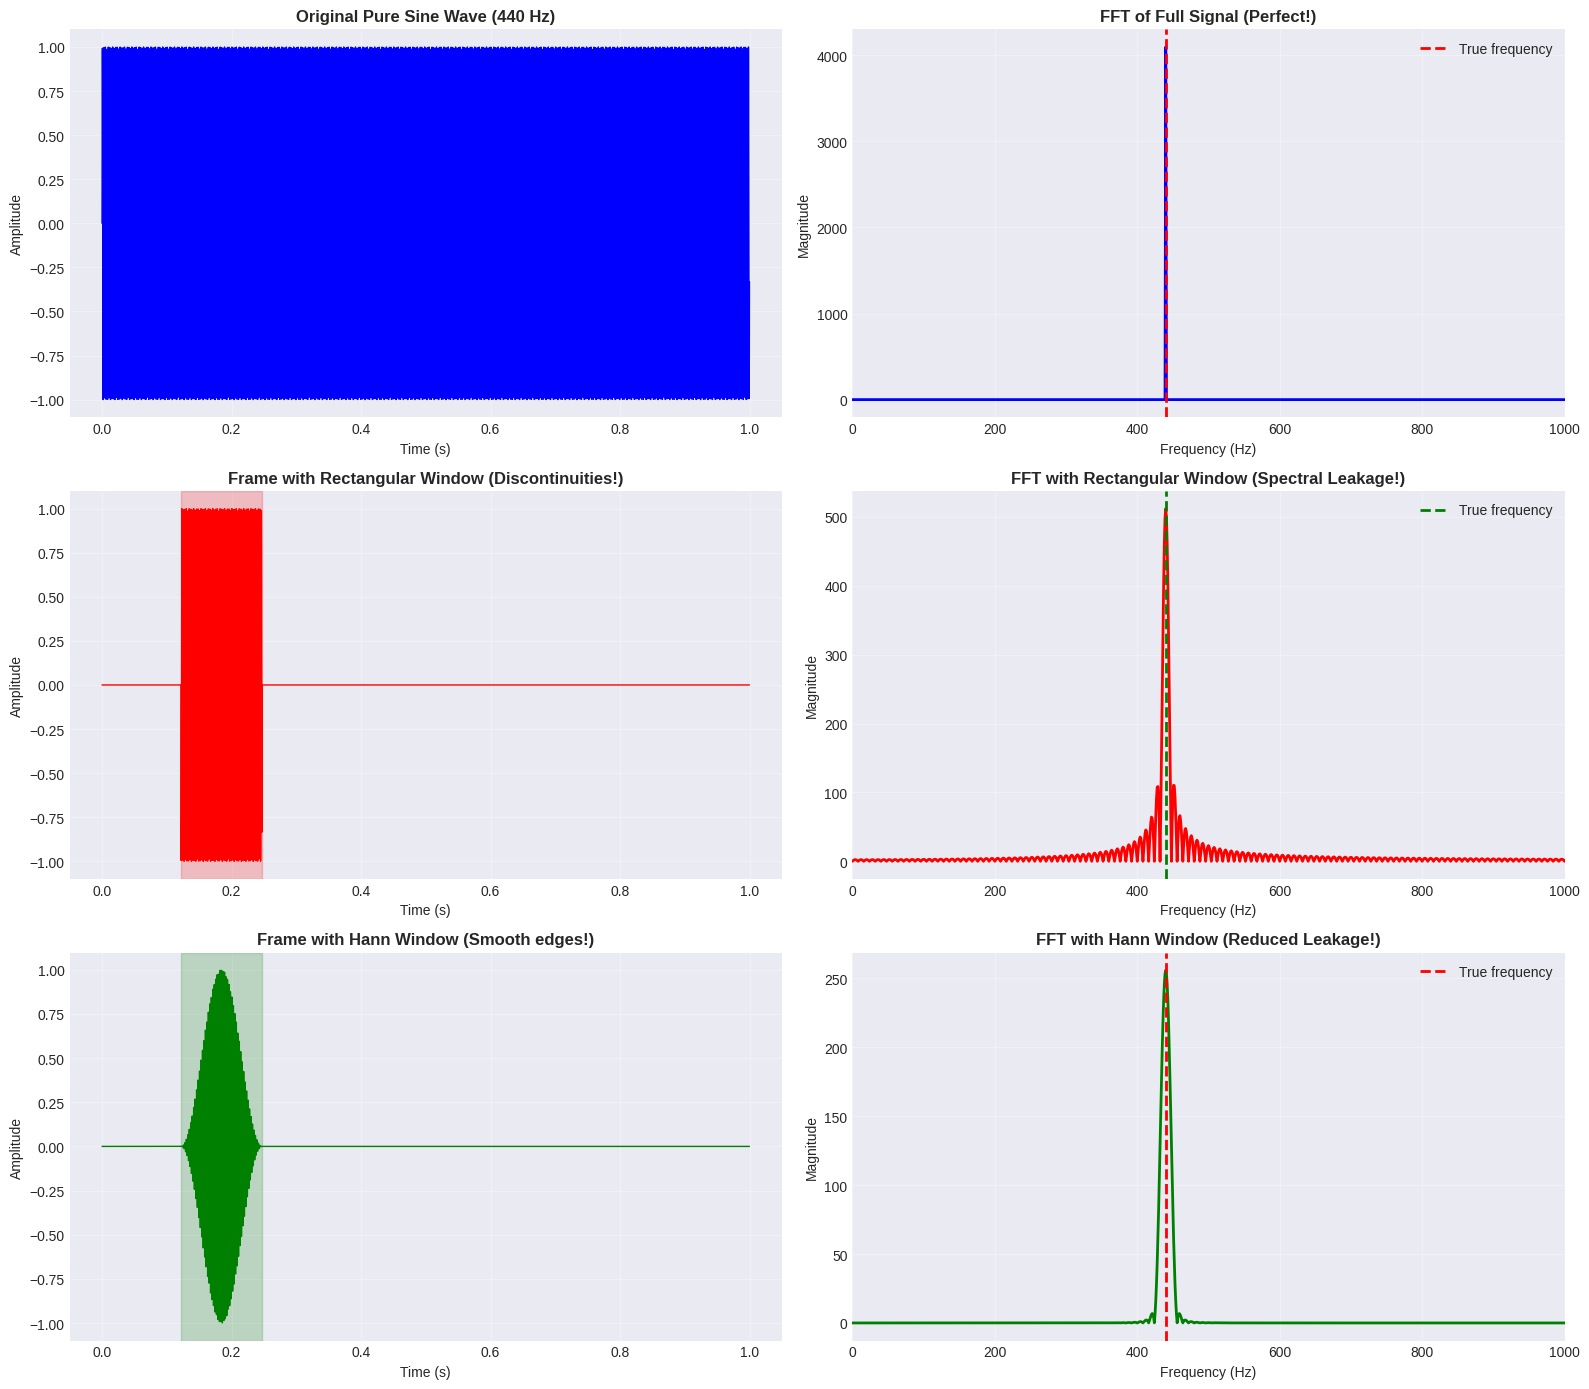


🔍 Spectral Leakage Analysis:

📘 TOP ROW (Full Signal):
   • Perfect sine wave, no discontinuities
   • FFT shows single sharp peak at 440 Hz ✓

📕 MIDDLE ROW (Rectangular Window):
   • Sudden start/stop creates discontinuities
   • FFT shows energy spread across many frequencies ✗
   • This is SPECTRAL LEAKAGE - fake frequencies appear!

📗 BOTTOM ROW (Hann Window):
   • Smooth fade-in/fade-out
   • FFT shows much cleaner peak at 440 Hz ✓
   • Leakage is greatly reduced!


In [4]:
# Demonstrate spectral leakage
sr_demo = 8192  # Use power of 2 for clean FFT
duration_demo = 1.0
t_demo = np.linspace(0, duration_demo, sr_demo, endpoint=False)

# Create a pure sine wave at 440 Hz
frequency = 440
pure_sine = np.sin(2 * np.pi * frequency * t_demo)

# Extract a frame (rectangular window)
frame_size = 1024
frame_start = 1000
frame_end = frame_start + frame_size

# Method 1: Rectangular window (causes leakage)
frame_rect = np.zeros(sr_demo)
frame_rect[frame_start:frame_end] = pure_sine[frame_start:frame_end]

# Method 2: With Hann window (reduces leakage)
hann_window = np.hanning(frame_size)
frame_hann = np.zeros(sr_demo)
frame_hann[frame_start:frame_end] = pure_sine[frame_start:frame_end] * hann_window

# Compute FFT for both
fft_pure = np.abs(fft(pure_sine))
fft_rect = np.abs(fft(frame_rect))
fft_hann = np.abs(fft(frame_hann))

freqs = fftfreq(sr_demo, 1/sr_demo)

# Plot
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Row 1: Full signal
axes[0, 0].plot(t_demo, pure_sine, linewidth=1, color='blue')
axes[0, 0].set_title('Original Pure Sine Wave (440 Hz)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(freqs[:sr_demo//2], fft_pure[:sr_demo//2], linewidth=2, color='blue')
axes[0, 1].set_title('FFT of Full Signal (Perfect!)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Magnitude')
axes[0, 1].set_xlim(0, 1000)
axes[0, 1].axvline(x=440, color='red', linestyle='--', linewidth=2, label='True frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Rectangular window
axes[1, 0].plot(t_demo, frame_rect, linewidth=1, color='red')
axes[1, 0].axvspan(frame_start/sr_demo, frame_end/sr_demo, alpha=0.2, color='red')
axes[1, 0].set_title('Frame with Rectangular Window (Discontinuities!)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(freqs[:sr_demo//2], fft_rect[:sr_demo//2], linewidth=2, color='red')
axes[1, 1].set_title('FFT with Rectangular Window (Spectral Leakage!)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_xlim(0, 1000)
axes[1, 1].axvline(x=440, color='green', linestyle='--', linewidth=2, label='True frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Row 3: Hann window
axes[2, 0].plot(t_demo, frame_hann, linewidth=1, color='green')
axes[2, 0].axvspan(frame_start/sr_demo, frame_end/sr_demo, alpha=0.2, color='green')
axes[2, 0].set_title('Frame with Hann Window (Smooth edges!)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Time (s)')
axes[2, 0].set_ylabel('Amplitude')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(freqs[:sr_demo//2], fft_hann[:sr_demo//2], linewidth=2, color='green')
axes[2, 1].set_title('FFT with Hann Window (Reduced Leakage!)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Frequency (Hz)')
axes[2, 1].set_ylabel('Magnitude')
axes[2, 1].set_xlim(0, 1000)
axes[2, 1].axvline(x=440, color='red', linestyle='--', linewidth=2, label='True frequency')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Spectral Leakage Analysis:")
print("\n📘 TOP ROW (Full Signal):")
print("   • Perfect sine wave, no discontinuities")
print("   • FFT shows single sharp peak at 440 Hz ✓")

print("\n📕 MIDDLE ROW (Rectangular Window):")
print("   • Sudden start/stop creates discontinuities")
print("   • FFT shows energy spread across many frequencies ✗")
print("   • This is SPECTRAL LEAKAGE - fake frequencies appear!")

print("\n📗 BOTTOM ROW (Hann Window):")
print("   • Smooth fade-in/fade-out")
print("   • FFT shows much cleaner peak at 440 Hz ✓")
print("   • Leakage is greatly reduced!")

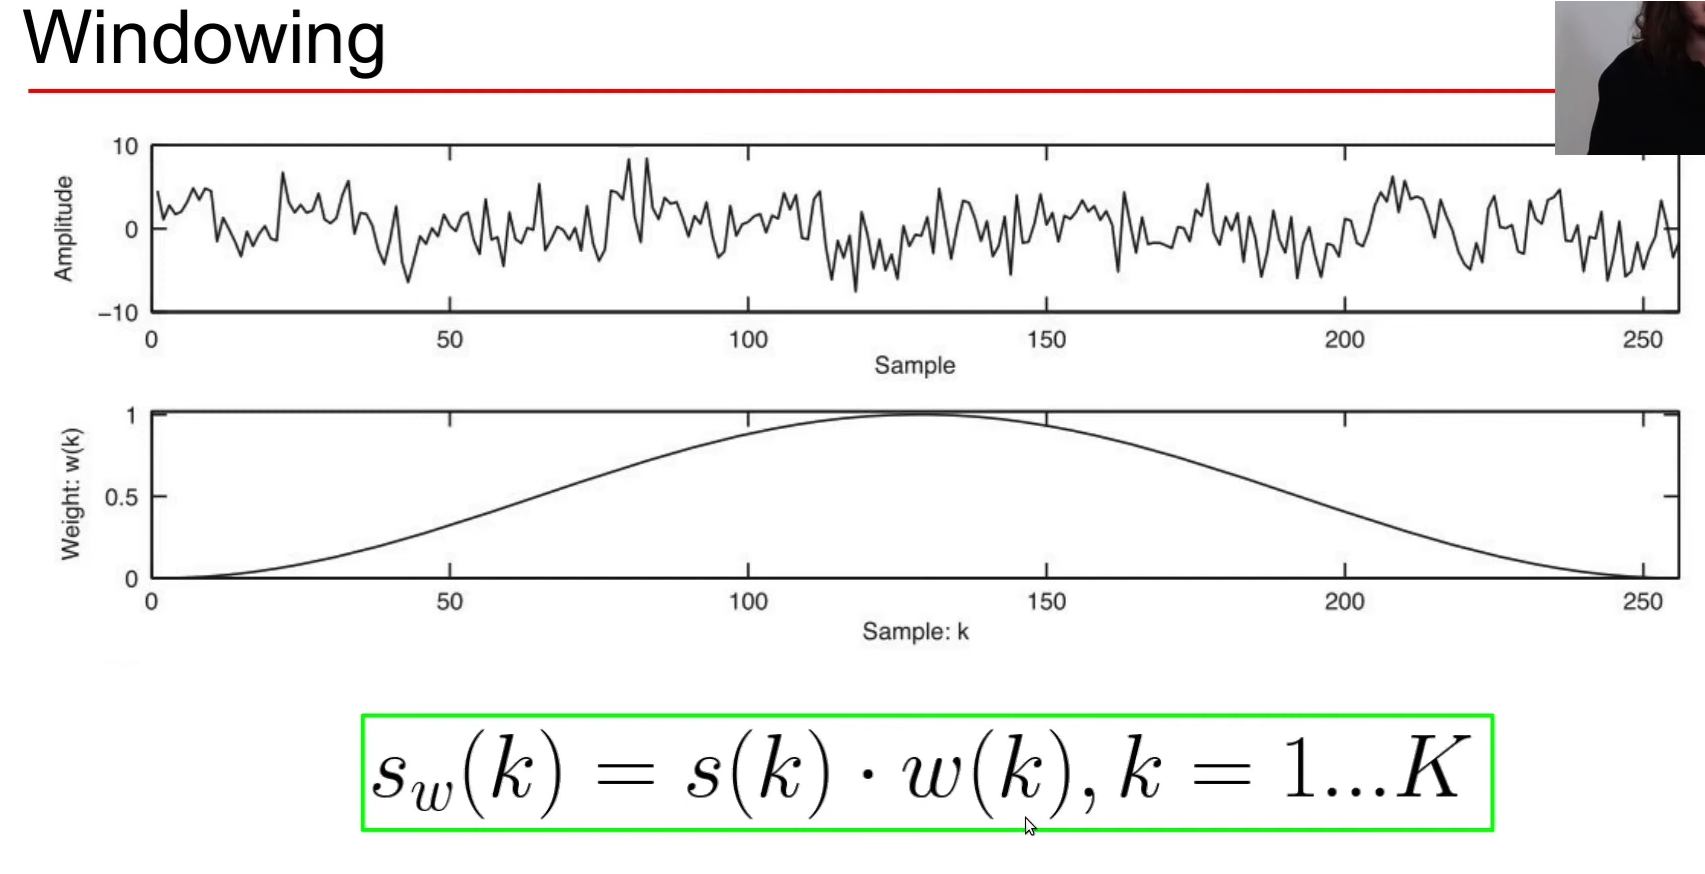

---

## 4. 🛠️ The Fix: Windowing Functions

### What is a Window Function?

A **window function** is a mathematical function that:
1. Smoothly tapers the signal to zero at the frame edges
2. Reduces discontinuities
3. Minimizes spectral leakage

Instead of multiplying by a rectangular window (0 or 1), we multiply by a smooth function that gradually fades in and out.

### Common Window Functions

#### 1. **Hann Window** (Most Common)

$$w(k) = 0.5 \cdot \left(1 - \cos\left(\frac{2\pi k}{K}\right)\right), \quad k = 0, 1, ..., K-1$$

- Smooth bell-shaped curve
- Good balance between main lobe width and side lobe suppression
- **Standard choice for audio processing**

#### 2. **Hamming Window**

$$w(k) = 0.54 - 0.46 \cdot \cos\left(\frac{2\pi k}{K}\right)$$

- Similar to Hann but doesn't go to zero at edges
- Better side lobe suppression
- Used in speech processing

#### 3. **Blackman Window**

$$w(k) = 0.42 - 0.5 \cdot \cos\left(\frac{2\pi k}{K}\right) + 0.08 \cdot \cos\left(\frac{4\pi k}{K}\right)$$

- Excellent side lobe suppression
- Wider main lobe (worse frequency resolution)
- Used when leakage must be minimized

Let's visualize and compare all window functions:

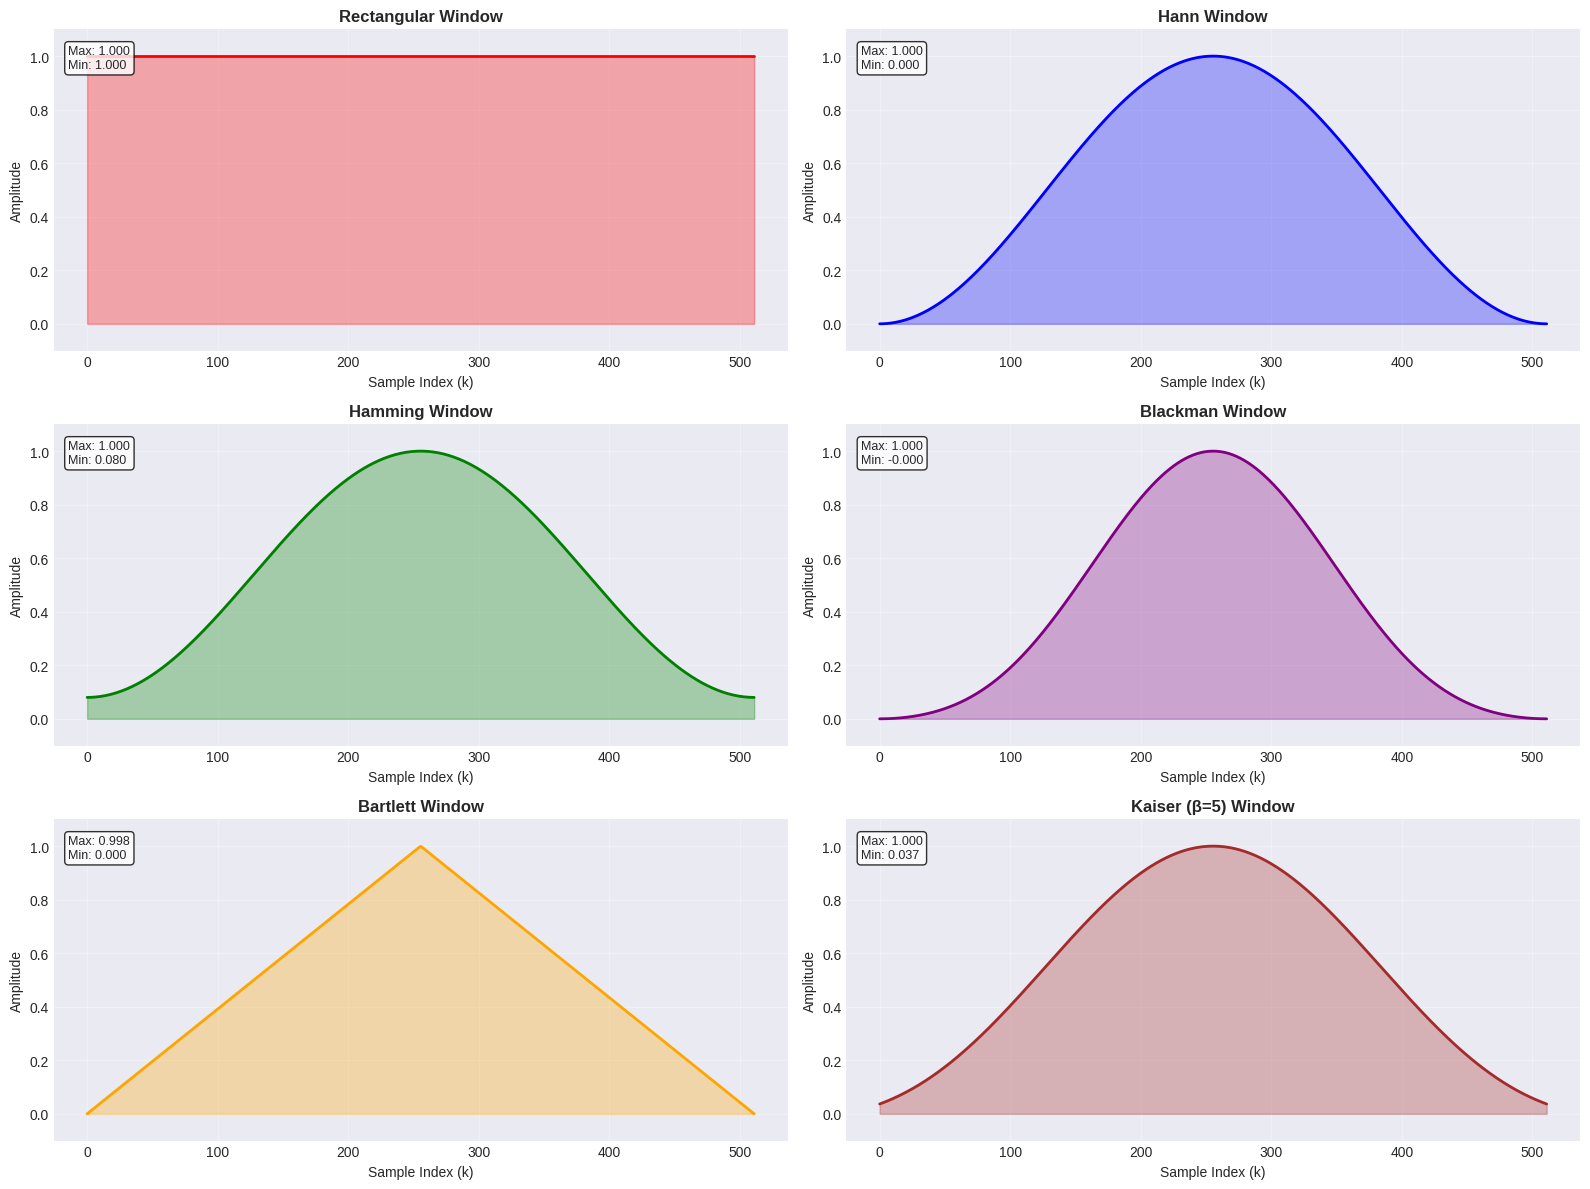


📊 Window Function Characteristics:

🔴 RECTANGULAR: No tapering, maximum leakage
🔵 HANN: Smooth bell curve, MOST COMMON for audio
🟢 HAMMING: Similar to Hann, better side lobe suppression
🟣 BLACKMAN: Excellent leakage suppression, wider main lobe
🟠 BARTLETT: Triangular shape, simple
🟤 KAISER: Adjustable parameter β controls shape


In [5]:
# Compare different window functions
frame_size_win = 512
k = np.arange(frame_size_win)

# Define window functions
windows = {
    'Rectangular': np.ones(frame_size_win),
    'Hann': np.hanning(frame_size_win),
    'Hamming': np.hamming(frame_size_win),
    'Blackman': np.blackman(frame_size_win),
    'Bartlett': np.bartlett(frame_size_win),
    'Kaiser (β=5)': np.kaiser(frame_size_win, 5)
}

# Plot time domain
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

colors_win = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

for idx, (name, window) in enumerate(windows.items()):
    ax = axes[idx]
    ax.plot(k, window, linewidth=2, color=colors_win[idx])
    ax.fill_between(k, 0, window, alpha=0.3, color=colors_win[idx])
    ax.set_title(f'{name} Window', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index (k)', fontsize=10)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)
    
    # Add statistics
    ax.text(0.02, 0.95, f'Max: {np.max(window):.3f}\nMin: {np.min(window):.3f}', 
           transform=ax.transAxes, fontsize=9,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
           verticalalignment='top')

plt.tight_layout()
plt.show()

print("\n📊 Window Function Characteristics:")
print("\n🔴 RECTANGULAR: No tapering, maximum leakage")
print("🔵 HANN: Smooth bell curve, MOST COMMON for audio")
print("🟢 HAMMING: Similar to Hann, better side lobe suppression")
print("🟣 BLACKMAN: Excellent leakage suppression, wider main lobe")
print("🟠 BARTLETT: Triangular shape, simple")
print("🟤 KAISER: Adjustable parameter β controls shape")

**If we're using a perfect sine wave that aligns exactly with the FFT bin frequencies. To see spectral leakage, we need a frequency that doesn't align with the FFT bins. Demo Below**

Plot saved as 'fft_window_comparison.png'


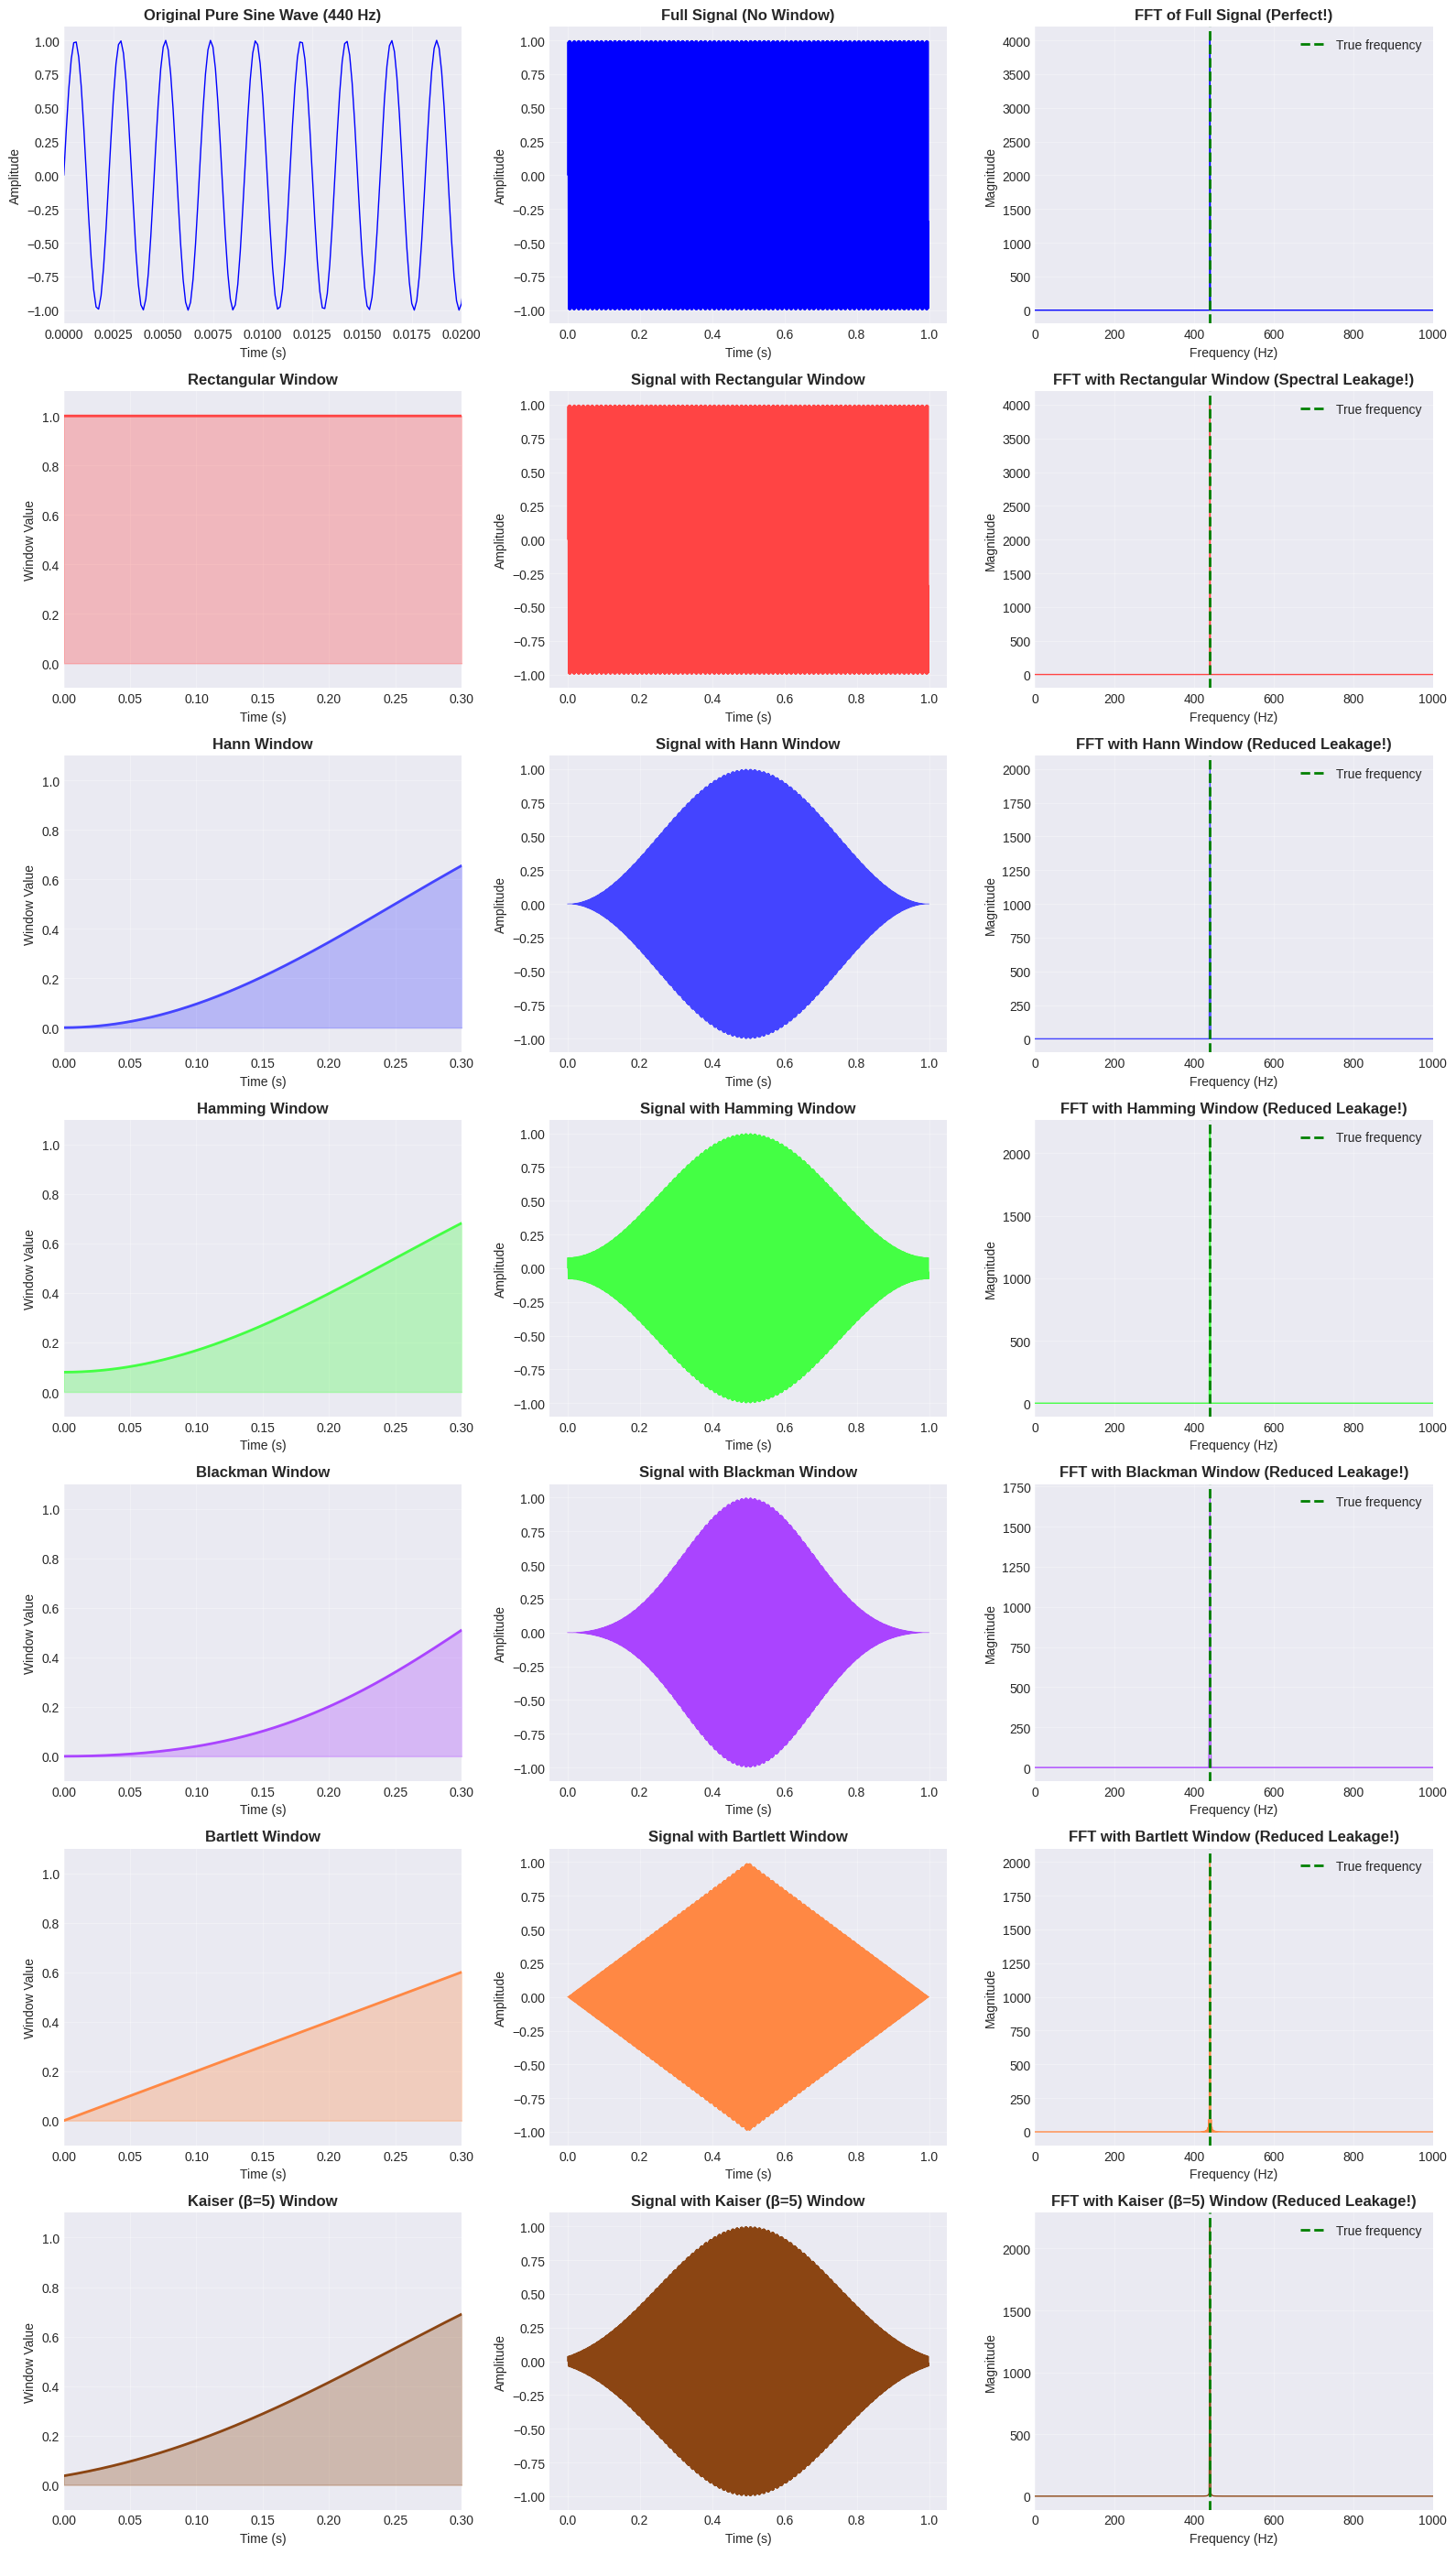


WINDOW CHARACTERISTICS SUMMARY

Rectangular:
  Max value: 1.0000
  Min value: 1.0000
  Mean value: 1.0000
  Peak frequency: 440.00 Hz
  -3dB Bandwidth: 0.00 Hz

Hann:
  Max value: 1.0000
  Min value: 0.0000
  Mean value: 0.4999
  Peak frequency: 440.00 Hz
  -3dB Bandwidth: 0.00 Hz

Hamming:
  Max value: 1.0000
  Min value: 0.0800
  Mean value: 0.5399
  Peak frequency: 440.00 Hz
  -3dB Bandwidth: 0.00 Hz

Blackman:
  Max value: 1.0000
  Min value: -0.0000
  Mean value: 0.4199
  Peak frequency: 440.00 Hz
  -3dB Bandwidth: 0.00 Hz

Bartlett:
  Max value: 0.9999
  Min value: 0.0000
  Mean value: 0.4999
  Peak frequency: 440.00 Hz
  -3dB Bandwidth: 0.00 Hz

Kaiser (β=5):
  Max value: 1.0000
  Min value: 0.0367
  Mean value: 0.5447
  Peak frequency: 440.00 Hz
  -3dB Bandwidth: 0.00 Hz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Signal parameters
duration = 1.0  # seconds
sample_rate = 8000  # Hz
frequency = 440  # Hz (A4 note)

# Generate time array
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate pure sine wave
pure_signal = np.sin(2 * np.pi * frequency * t)

# Define window functions to compare
windows = {
    'Rectangular': np.ones(len(t)),
    'Hann': signal.windows.hann(len(t)),
    'Hamming': signal.windows.hamming(len(t)),
    'Blackman': signal.windows.blackman(len(t)),
    'Bartlett': signal.windows.bartlett(len(t)),
    'Kaiser (β=5)': signal.windows.kaiser(len(t), beta=5)
}

# Colors for each window
colors = {
    'Rectangular': '#FF4444',
    'Hann': '#4444FF',
    'Hamming': '#44FF44',
    'Blackman': '#AA44FF',
    'Bartlett': '#FF8844',
    'Kaiser (β=5)': '#8B4513'
}

# Create figure with subplots
n_windows = len(windows)
fig = plt.figure(figsize=(16, 4 * (n_windows + 1)))

# Calculate FFT of original signal (no window)
fft_original = fft(pure_signal)
freqs = fftfreq(len(t), 1/sample_rate)
positive_freqs = freqs[:len(freqs)//2]
magnitude_original = np.abs(fft_original[:len(freqs)//2])

# Plot 1: Original Signal (Time Domain)
ax1 = plt.subplot(n_windows + 1, 3, 1)
ax1.plot(t, pure_signal, 'b-', linewidth=1)
ax1.set_xlim(0, 0.02)  # Show first 20ms
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Original Pure Sine Wave ({frequency} Hz)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1.1, 1.1)

# Plot 2: Original Signal (Full Time Domain)
ax2 = plt.subplot(n_windows + 1, 3, 2)
ax2.plot(t, pure_signal, 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Full Signal (No Window)', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-1.1, 1.1)

# Plot 3: FFT of Original Signal
ax3 = plt.subplot(n_windows + 1, 3, 3)
ax3.plot(positive_freqs, magnitude_original, 'b-', linewidth=1)
ax3.axvline(frequency, color='green', linestyle='--', linewidth=2, label='True frequency')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.set_title('FFT of Full Signal (Perfect!)', fontweight='bold')
ax3.set_xlim(0, 1000)
ax3.grid(True, alpha=0.3)
ax3.legend()

# Process each window
for idx, (window_name, window) in enumerate(windows.items(), start=1):
    # Apply window to signal
    windowed_signal = pure_signal * window
    
    # Calculate FFT
    fft_windowed = fft(windowed_signal)
    magnitude_windowed = np.abs(fft_windowed[:len(freqs)//2])
    
    # Get color for this window
    color = colors[window_name]
    
    # Plot 1: Window shape (zoomed)
    ax1 = plt.subplot(n_windows + 1, 3, idx * 3 + 1)
    ax1.fill_between(t, 0, window, color=color, alpha=0.3)
    ax1.plot(t, window, color=color, linewidth=2)
    ax1.set_xlim(0, 0.3)  # Show first 300ms
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Window Value')
    ax1.set_title(f'{window_name} Window', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.1, 1.1)
    
    # Plot 2: Windowed signal
    ax2 = plt.subplot(n_windows + 1, 3, idx * 3 + 2)
    ax2.plot(t, windowed_signal, color=color, linewidth=0.5)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'Signal with {window_name} Window', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-1.1, 1.1)
    
    # Plot 3: FFT of windowed signal
    ax3 = plt.subplot(n_windows + 1, 3, idx * 3 + 3)
    ax3.plot(positive_freqs, magnitude_windowed, color=color, linewidth=1)
    ax3.axvline(frequency, color='green', linestyle='--', linewidth=2, label='True frequency')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Magnitude')
    
    # Add spectral leakage annotation
    if window_name == 'Rectangular':
        ax3.set_title(f'FFT with {window_name} Window (Spectral Leakage!) ', fontweight='bold')
    else:
        ax3.set_title(f'FFT with {window_name} Window (Reduced Leakage!)', fontweight='bold')
    
    ax3.set_xlim(0, 1000)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

plt.tight_layout()
plt.savefig('fft_window_comparison.png', dpi=150, bbox_inches='tight')
print("Plot saved as 'fft_window_comparison.png'")
plt.show()

# Print window characteristics
print("\n" + "="*60)
print("WINDOW CHARACTERISTICS SUMMARY")
print("="*60)

for window_name, window in windows.items():
    # Calculate some basic statistics
    max_val = np.max(window)
    min_val = np.min(window)
    mean_val = np.mean(window)
    
    print(f"\n{window_name}:")
    print(f"  Max value: {max_val:.4f}")
    print(f"  Min value: {min_val:.4f}")
    print(f"  Mean value: {mean_val:.4f}")
    
    # Calculate main lobe width (approximate)
    windowed_signal = pure_signal * window
    fft_windowed = fft(windowed_signal)
    magnitude_windowed = np.abs(fft_windowed[:len(freqs)//2])
    
    # Find peak
    peak_idx = np.argmax(magnitude_windowed)
    peak_freq = positive_freqs[peak_idx]
    peak_magnitude = magnitude_windowed[peak_idx]
    
    # Find -3dB bandwidth
    half_power = peak_magnitude / np.sqrt(2)
    above_half_power = magnitude_windowed > half_power
    bandwidth_indices = np.where(above_half_power)[0]
    
    if len(bandwidth_indices) > 0:
        bandwidth = positive_freqs[bandwidth_indices[-1]] - positive_freqs[bandwidth_indices[0]]
        print(f"  Peak frequency: {peak_freq:.2f} Hz")
        print(f"  -3dB Bandwidth: {bandwidth:.2f} Hz")

Plot saved as 'fft_window_comparison.png'


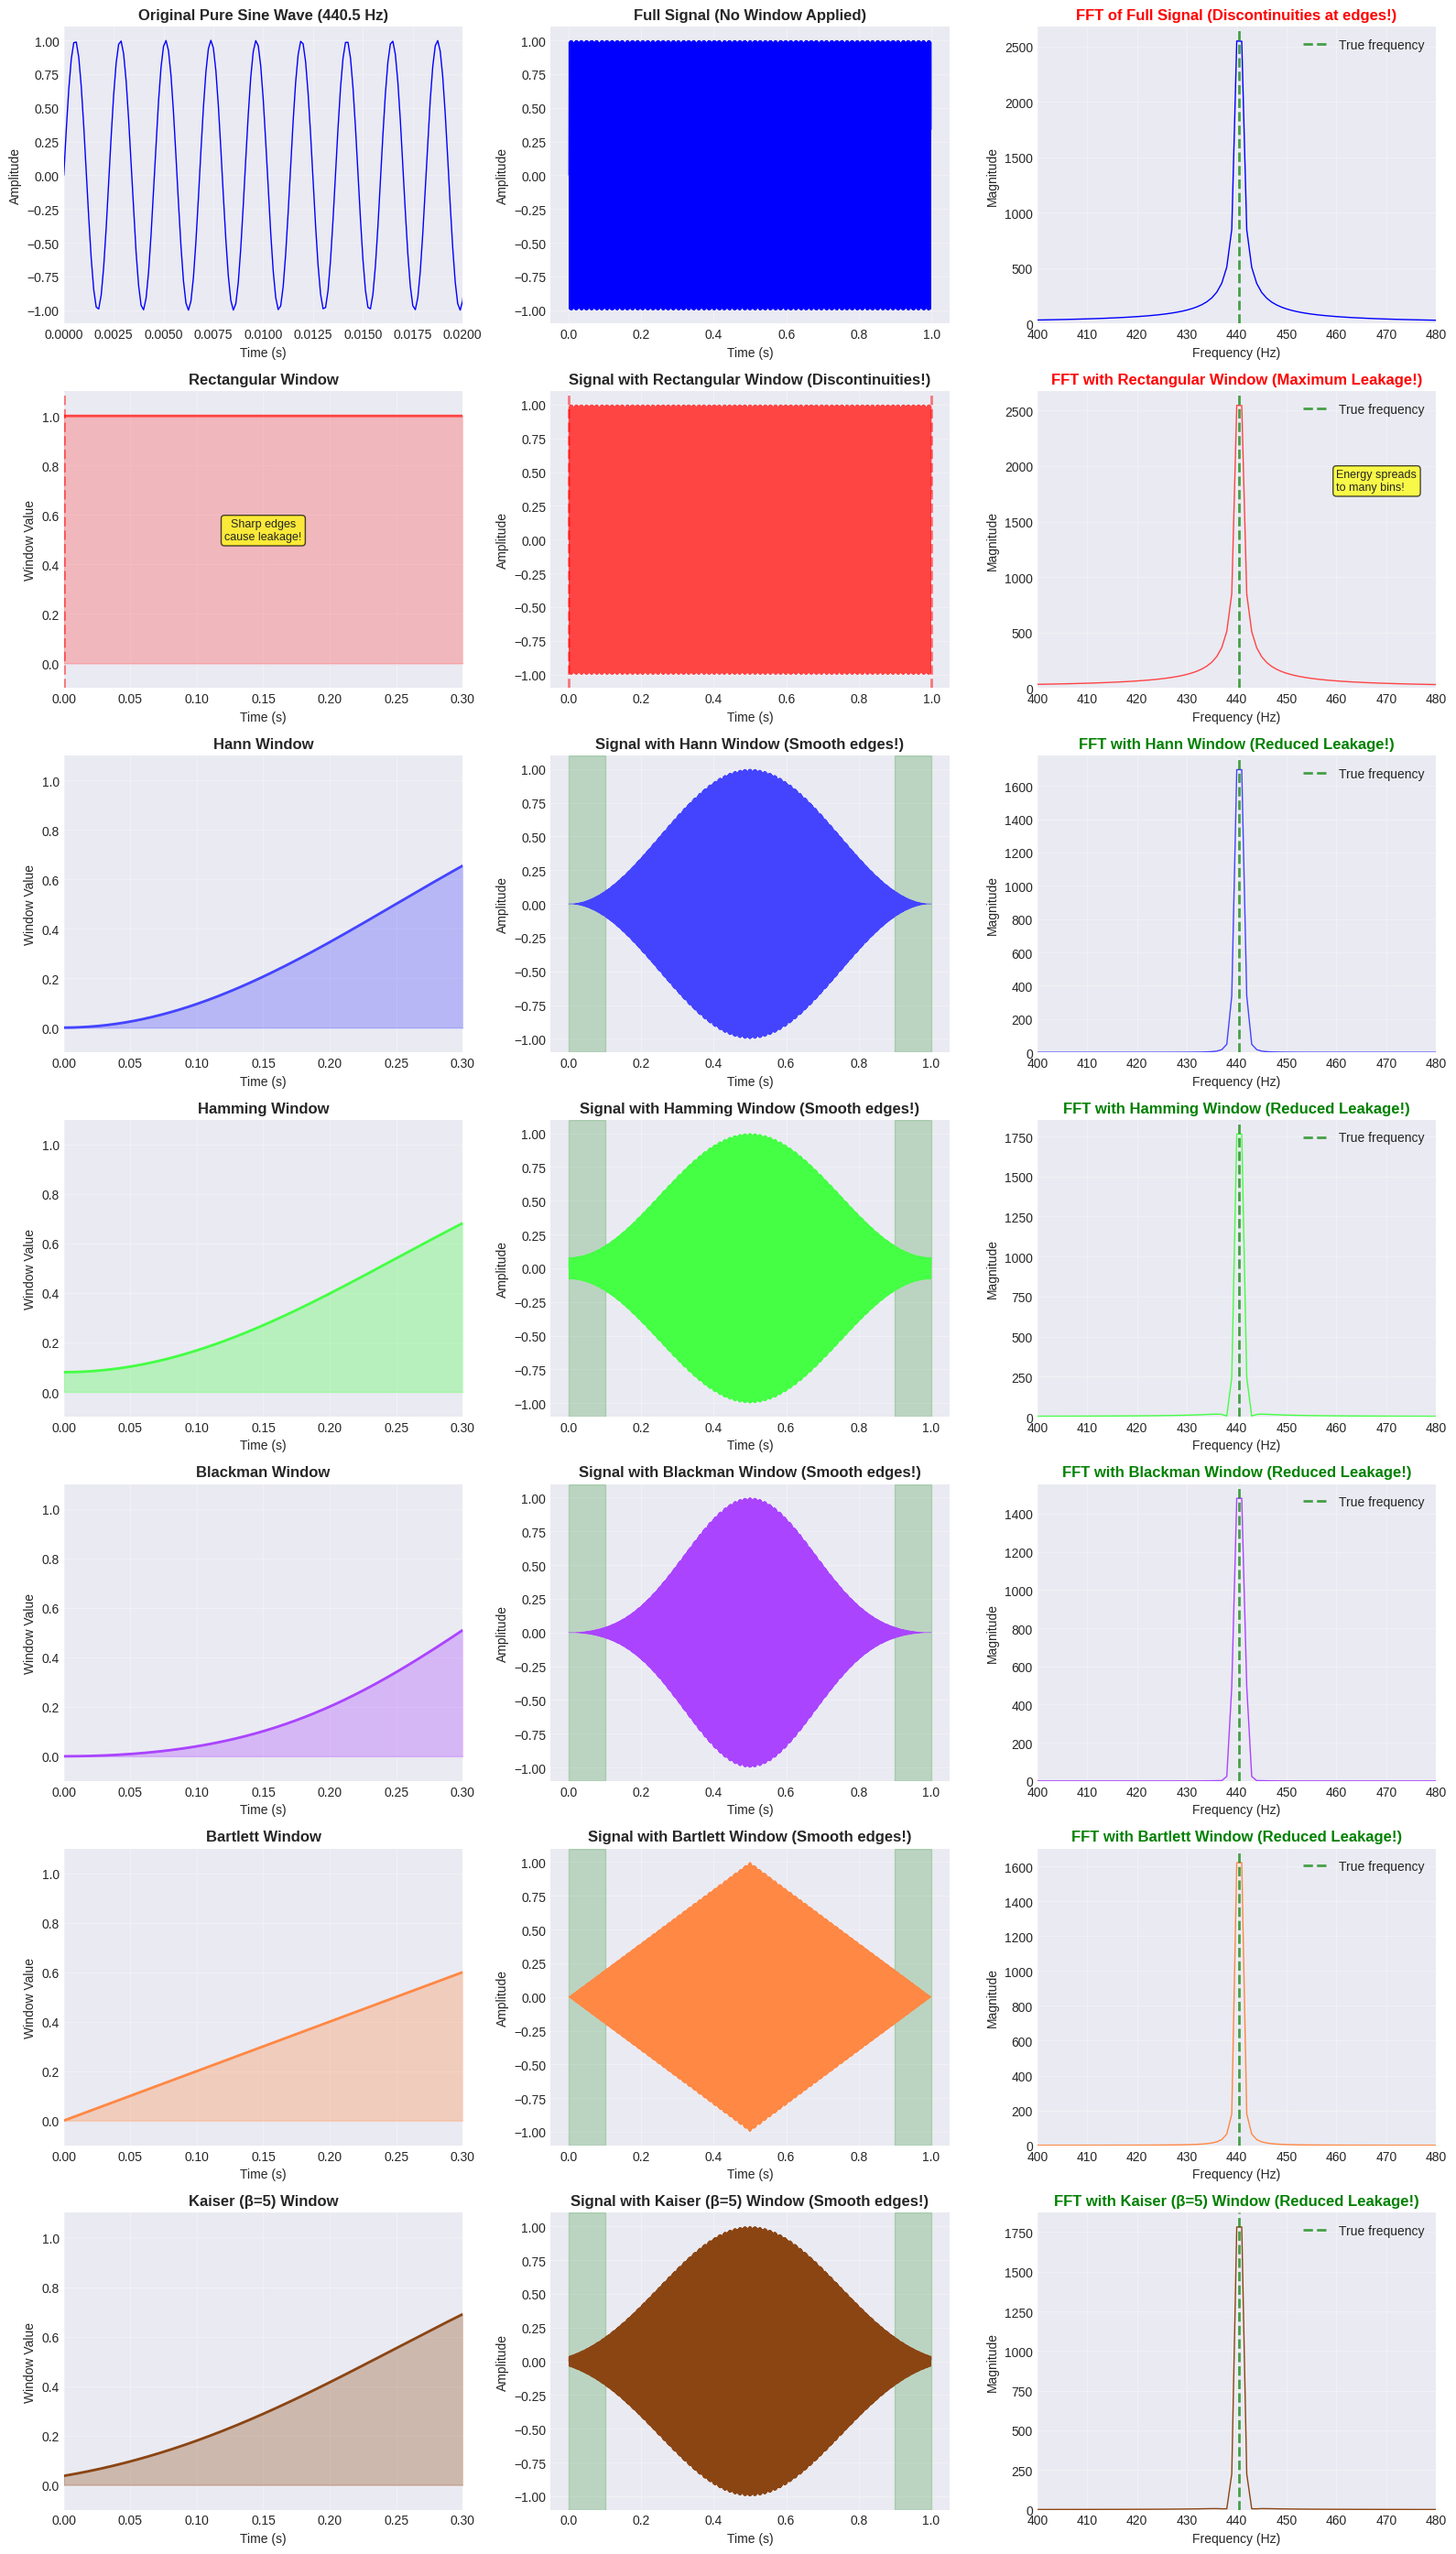


WINDOW CHARACTERISTICS SUMMARY

Signal frequency: 440.5 Hz (NOT aligned with FFT bins!)
FFT bin spacing: 1.0 Hz
This causes SPECTRAL LEAKAGE - energy spreads to adjacent bins


Rectangular:
  Max value: 1.0000
  Min value: 1.0000
  Mean value: 1.0000
  Peak frequency: 440.00 Hz (True: 440.5 Hz)
  Peak magnitude: 2547.9
  Leakage ratio: 59.00% (lower is better)

Hann:
  Max value: 1.0000
  Min value: 0.0000
  Mean value: 0.4999
  Peak frequency: 441.00 Hz (True: 440.5 Hz)
  Peak magnitude: 1697.5
  Leakage ratio: 51.97% (lower is better)

Hamming:
  Max value: 1.0000
  Min value: 0.0800
  Mean value: 0.5399
  Peak frequency: 440.00 Hz (True: 440.5 Hz)
  Peak magnitude: 1765.5
  Leakage ratio: 50.96% (lower is better)

Blackman:
  Max value: 1.0000
  Min value: -0.0000
  Mean value: 0.4199
  Peak frequency: 441.00 Hz (True: 440.5 Hz)
  Peak magnitude: 1480.2
  Leakage ratio: 55.04% (lower is better)

Bartlett:
  Max value: 0.9999
  Min value: 0.0000
  Mean value: 0.4999
  Peak frequency

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Signal parameters
duration = 1.0  # seconds
sample_rate = 8000  # Hz
frequency = 440.5  # Hz - NOT aligned with FFT bins! This causes leakage
# With 8000 samples, FFT bins are at 0, 1, 2, 3... Hz
# 440.5 Hz falls BETWEEN bins, causing spectral leakage

# Generate time array
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate pure sine wave
pure_signal = np.sin(2 * np.pi * frequency * t)

# Define window functions to compare
windows = {
    'Rectangular': np.ones(len(t)),
    'Hann': signal.windows.hann(len(t)),
    'Hamming': signal.windows.hamming(len(t)),
    'Blackman': signal.windows.blackman(len(t)),
    'Bartlett': signal.windows.bartlett(len(t)),
    'Kaiser (β=5)': signal.windows.kaiser(len(t), beta=5)
}

# Colors for each window
colors = {
    'Rectangular': '#FF4444',
    'Hann': '#4444FF',
    'Hamming': '#44FF44',
    'Blackman': '#AA44FF',
    'Bartlett': '#FF8844',
    'Kaiser (β=5)': '#8B4513'
}

# Create figure with subplots
n_windows = len(windows)
fig = plt.figure(figsize=(16, 4 * (n_windows + 1)))

# Calculate FFT of original signal (no window)
fft_original = fft(pure_signal)
freqs = fftfreq(len(t), 1/sample_rate)
positive_freqs = freqs[:len(freqs)//2]
magnitude_original = np.abs(fft_original[:len(freqs)//2])

# Plot 1: Original Signal (Time Domain)
ax1 = plt.subplot(n_windows + 1, 3, 1)
ax1.plot(t, pure_signal, 'b-', linewidth=1)
ax1.set_xlim(0, 0.02)  # Show first 20ms
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Original Pure Sine Wave ({frequency} Hz)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1.1, 1.1)

# Plot 2: Original Signal (Full Time Domain)
ax2 = plt.subplot(n_windows + 1, 3, 2)
ax2.plot(t, pure_signal, 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Full Signal (No Window Applied)', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-1.1, 1.1)

# Plot 3: FFT of Original Signal
ax3 = plt.subplot(n_windows + 1, 3, 3)
ax3.plot(positive_freqs, magnitude_original, 'b-', linewidth=1)
ax3.axvline(frequency, color='green', linestyle='--', linewidth=2, label='True frequency', alpha=0.7)
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.set_title('FFT of Full Signal (Discontinuities at edges!)', fontweight='bold', color='red')
ax3.set_xlim(400, 480)  # Zoom to show leakage
ax3.set_ylim(0, None)
ax3.grid(True, alpha=0.3)
ax3.legend()

# Process each window
for idx, (window_name, window) in enumerate(windows.items(), start=1):
    # Apply window to signal
    windowed_signal = pure_signal * window
    
    # Calculate FFT
    fft_windowed = fft(windowed_signal)
    magnitude_windowed = np.abs(fft_windowed[:len(freqs)//2])
    
    # Get color for this window
    color = colors[window_name]
    
    # Plot 1: Window shape (zoomed)
    ax1 = plt.subplot(n_windows + 1, 3, idx * 3 + 1)
    ax1.fill_between(t, 0, window, color=color, alpha=0.3)
    ax1.plot(t, window, color=color, linewidth=2)
    ax1.set_xlim(0, 0.3)  # Show first 300ms
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Window Value')
    ax1.set_title(f'{window_name} Window', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.1, 1.1)
    
    # Highlight discontinuities for rectangular
    if window_name == 'Rectangular':
        ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
        ax1.text(0.15, 0.5, 'Sharp edges\ncause leakage!', 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                fontsize=9, ha='center')
    
    # Plot 2: Windowed signal
    ax2 = plt.subplot(n_windows + 1, 3, idx * 3 + 2)
    ax2.plot(t, windowed_signal, color=color, linewidth=0.5)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    
    # Highlight smooth edges for non-rectangular windows
    if window_name != 'Rectangular':
        ax2.set_title(f'Signal with {window_name} Window (Smooth edges!)', fontweight='bold')
        # Highlight the tapered edges
        ax2.axvspan(0, 0.1, alpha=0.2, color='green', label='Tapered edges')
        ax2.axvspan(0.9, 1.0, alpha=0.2, color='green')
    else:
        ax2.set_title(f'Signal with {window_name} Window (Discontinuities!)', fontweight='bold')
        # Highlight the discontinuities
        ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
        ax2.axvline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-1.1, 1.1)
    
    # Plot 3: FFT of windowed signal
    ax3 = plt.subplot(n_windows + 1, 3, idx * 3 + 3)
    ax3.plot(positive_freqs, magnitude_windowed, color=color, linewidth=1)
    ax3.axvline(frequency, color='green', linestyle='--', linewidth=2, label='True frequency', alpha=0.7)
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Magnitude')
    
    # Add spectral leakage annotation
    if window_name == 'Rectangular':
        ax3.set_title(f'FFT with {window_name} Window (Maximum Leakage!)', 
                     fontweight='bold', color='red')
        # Annotate the leakage
        ax3.text(460, np.max(magnitude_windowed) * 0.7, 
                'Energy spreads\nto many bins!', 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                fontsize=9)
    else:
        ax3.set_title(f'FFT with {window_name} Window (Reduced Leakage!)', 
                     fontweight='bold', color='green')
    
    ax3.set_xlim(400, 480)  # Zoom to show leakage clearly
    ax3.set_ylim(0, None)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

plt.tight_layout()
plt.savefig('fft_window_comparison.png', dpi=150, bbox_inches='tight')
print("Plot saved as 'fft_window_comparison.png'")
plt.show()

# Print window characteristics
print("\n" + "="*70)
print("WINDOW CHARACTERISTICS SUMMARY")
print("="*70)
print(f"\nSignal frequency: {frequency} Hz (NOT aligned with FFT bins!)")
print(f"FFT bin spacing: {sample_rate / len(t)} Hz")
print(f"This causes SPECTRAL LEAKAGE - energy spreads to adjacent bins\n")

for window_name, window in windows.items():
    # Calculate some basic statistics
    max_val = np.max(window)
    min_val = np.min(window)
    mean_val = np.mean(window)
    
    print(f"\n{window_name}:")
    print(f"  Max value: {max_val:.4f}")
    print(f"  Min value: {min_val:.4f}")
    print(f"  Mean value: {mean_val:.4f}")
    
    # Calculate main lobe width and leakage
    windowed_signal = pure_signal * window
    fft_windowed = fft(windowed_signal)
    magnitude_windowed = np.abs(fft_windowed[:len(freqs)//2])
    
    # Find peak
    peak_idx = np.argmax(magnitude_windowed)
    peak_freq = positive_freqs[peak_idx]
    peak_magnitude = magnitude_windowed[peak_idx]
    
    # Calculate leakage (energy outside main lobe)
    # Define region around true frequency
    freq_range = (positive_freqs > 420) & (positive_freqs < 460)
    total_energy = np.sum(magnitude_windowed[freq_range]**2)
    
    # Energy in peak bin
    peak_energy = peak_magnitude**2
    leakage_ratio = (total_energy - peak_energy) / total_energy * 100
    
    print(f"  Peak frequency: {peak_freq:.2f} Hz (True: {frequency} Hz)")
    print(f"  Peak magnitude: {peak_magnitude:.1f}")
    print(f"  Leakage ratio: {leakage_ratio:.2f}% (lower is better)")

**Windowing solves leakage, but it creates a new problem: Data Loss.**
        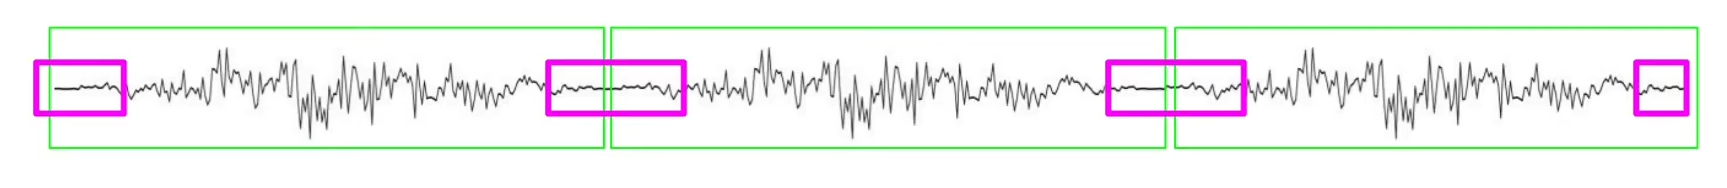

**The Solution - Overlapping Frames**
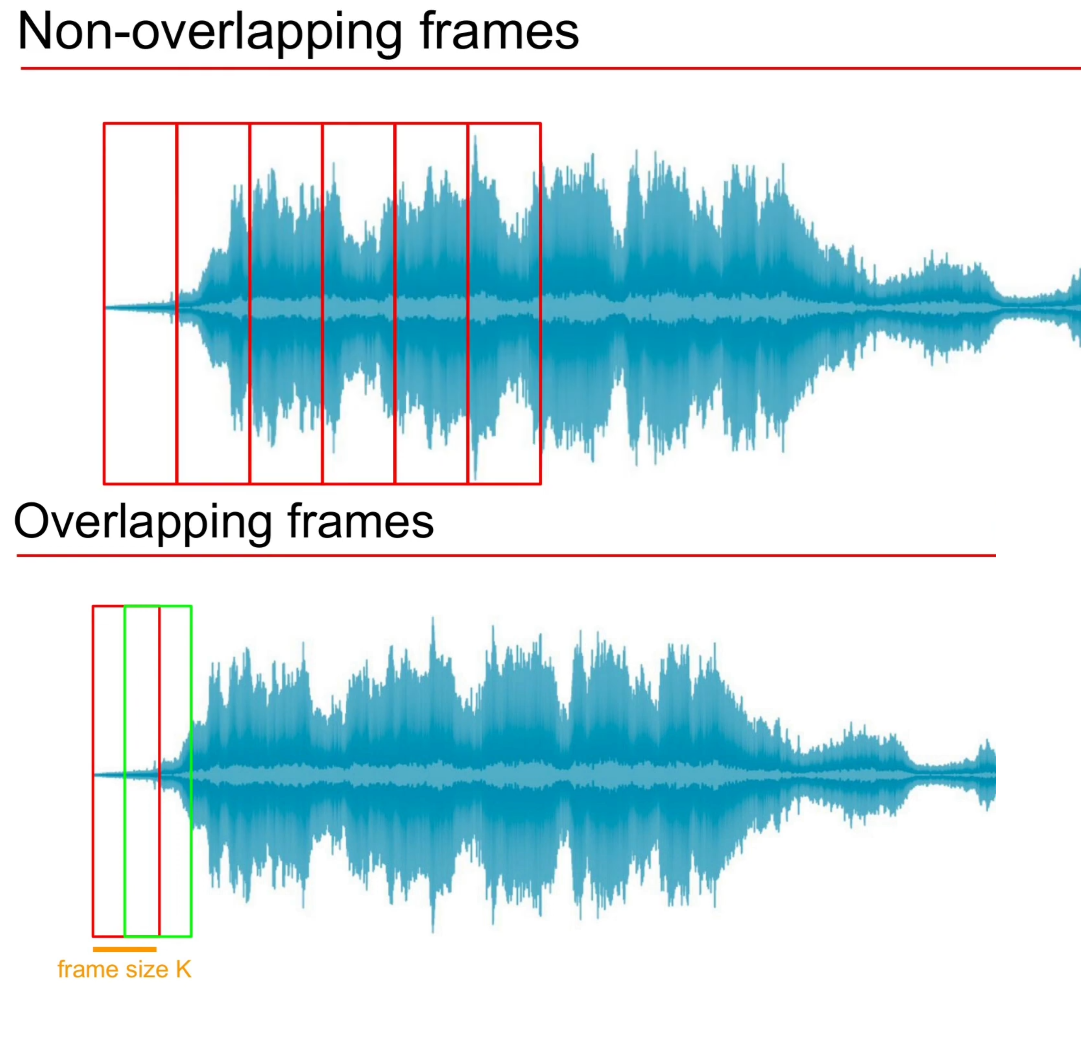

---

## 5. 📏 Hop Length and Overlap

### What is Hop Length?

**Hop Length** is the number of samples we move forward between consecutive frames.

- **Hop Length = Frame Size**: Non-overlapping frames (data loss!)
- **Hop Length < Frame Size**: Overlapping frames (recommended)

### Why Overlap?

1. **Prevent Data Loss**: Window functions reduce signal at edges
2. **Smooth Transitions**: Overlapping ensures no information is lost
3. **Better Time Resolution**: More frames = finer time granularity

### Common Settings

- **50% Overlap**: Hop Length = Frame Size / 2 (most common)
- **75% Overlap**: Hop Length = Frame Size / 4 (high quality)

Let's visualize overlapping frames:

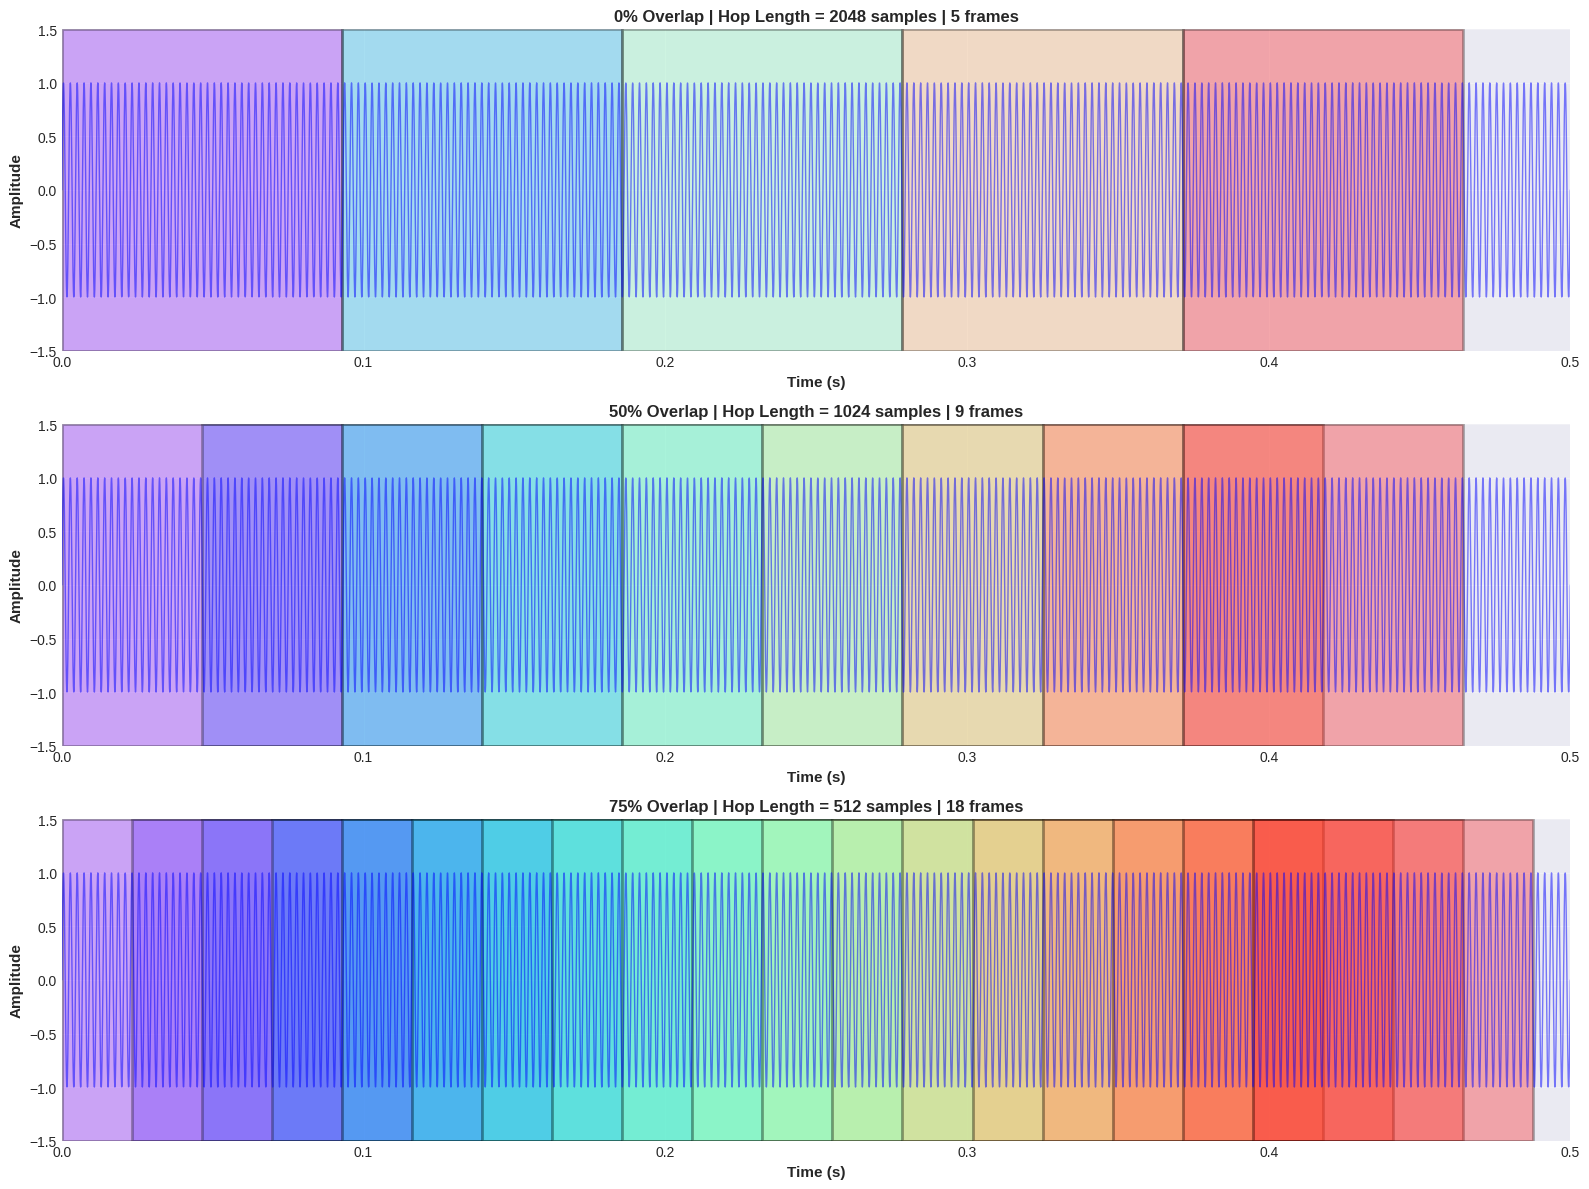


📏 Hop Length Analysis:

0% Overlap (Top): Non-overlapping frames - potential data loss at edges
50% Overlap (Middle): STANDARD - good balance
75% Overlap (Bottom): High quality - more computation


In [6]:
# Visualize overlapping vs non-overlapping frames
sr_overlap = 22050
duration_overlap = 0.5
t_overlap = np.linspace(0, duration_overlap, int(sr_overlap * duration_overlap))
signal_overlap = np.sin(2 * np.pi * 440 * t_overlap)

frame_size_overlap = 2048
hop_lengths = [frame_size_overlap, frame_size_overlap // 2, frame_size_overlap // 4]
overlap_percentages = [0, 50, 75]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for idx, (hop_length, overlap_pct) in enumerate(zip(hop_lengths, overlap_percentages)):
    ax = axes[idx]
    
    # Plot signal
    ax.plot(t_overlap, signal_overlap, linewidth=1, color='blue', alpha=0.5)
    
    # Draw frames
    num_frames = int((len(signal_overlap) - frame_size_overlap) / hop_length) + 1
    colors_overlap = plt.cm.rainbow(np.linspace(0, 1, num_frames))
    
    for i in range(num_frames):
        start_sample = i * hop_length
        end_sample = start_sample + frame_size_overlap
        
        if end_sample > len(signal_overlap):
            break
            
        start_time = start_sample / sr_overlap
        end_time = end_sample / sr_overlap
        
        # Draw rectangle
        rect = Rectangle((start_time, -1.5), end_time - start_time, 3,
                        alpha=0.3, facecolor=colors_overlap[i], edgecolor='black', linewidth=2)
        ax.add_patch(rect)
    
    ax.set_xlim(0, duration_overlap)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
    ax.set_title(f'{overlap_pct}% Overlap | Hop Length = {hop_length} samples | {num_frames} frames',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📏 Hop Length Analysis:")
print("\n0% Overlap (Top): Non-overlapping frames - potential data loss at edges")
print("50% Overlap (Middle): STANDARD - good balance")
print("75% Overlap (Bottom): High quality - more computation")

---

## 6. 🐍 Implementation in Python (Librosa)

Now let's put it all together using librosa to compute spectrograms with proper framing and windowing:

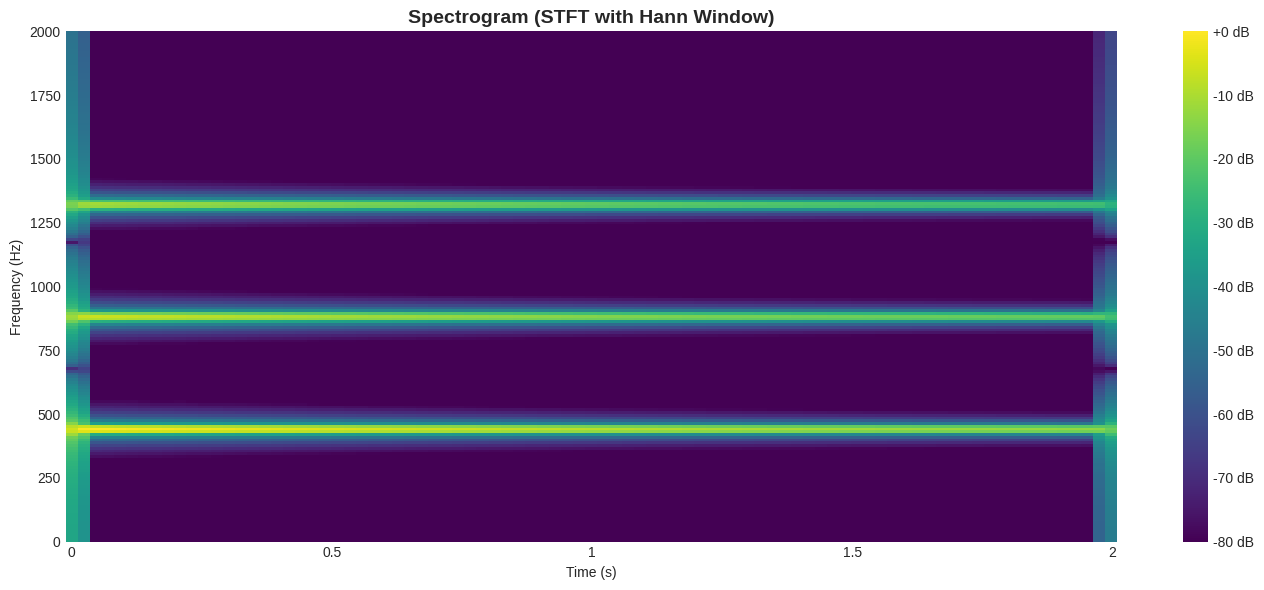


🎵 Librosa STFT Parameters:
   • n_fft: 2048 (frame size)
   • hop_length: 512 (50% overlap)
   • window: 'hann'
   • Sample rate: 22050 Hz

   Frame duration: 92.9 ms
   Hop duration: 23.2 ms
   Spectrogram shape: (1025, 87)
   Frequency bins: 1025
   Time frames: 87


In [7]:
# Create a demo audio signal
sr_final = 22050
duration_final = 2.0
t_final = np.linspace(0, duration_final, int(sr_final * duration_final))

# Complex signal with multiple components
audio_final = (
    np.sin(2 * np.pi * 440 * t_final) +
    0.5 * np.sin(2 * np.pi * 880 * t_final) +
    0.3 * np.sin(2 * np.pi * 1320 * t_final)
)

# Add envelope
envelope_final = np.exp(-1.5 * t_final) + 0.2
audio_final = audio_final * envelope_final

# Compute STFT with librosa
n_fft = 2048
hop_length_final = 512
window_type = 'hann'

D = librosa.stft(audio_final, n_fft=n_fft, hop_length=hop_length_final, window=window_type)
magnitude = np.abs(D)
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(magnitude_db, sr=sr_final, hop_length=hop_length_final,
                        x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT with Hann Window)', fontsize=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

print("\n🎵 Librosa STFT Parameters:")
print(f"   • n_fft: {n_fft} (frame size)")
print(f"   • hop_length: {hop_length_final} (50% overlap)")
print(f"   • window: '{window_type}'")
print(f"   • Sample rate: {sr_final} Hz")
print(f"\n   Frame duration: {n_fft/sr_final*1000:.1f} ms")
print(f"   Hop duration: {hop_length_final/sr_final*1000:.1f} ms")
print(f"   Spectrogram shape: {magnitude.shape}")
print(f"   Frequency bins: {magnitude.shape[0]}")
print(f"   Time frames: {magnitude.shape[1]}")

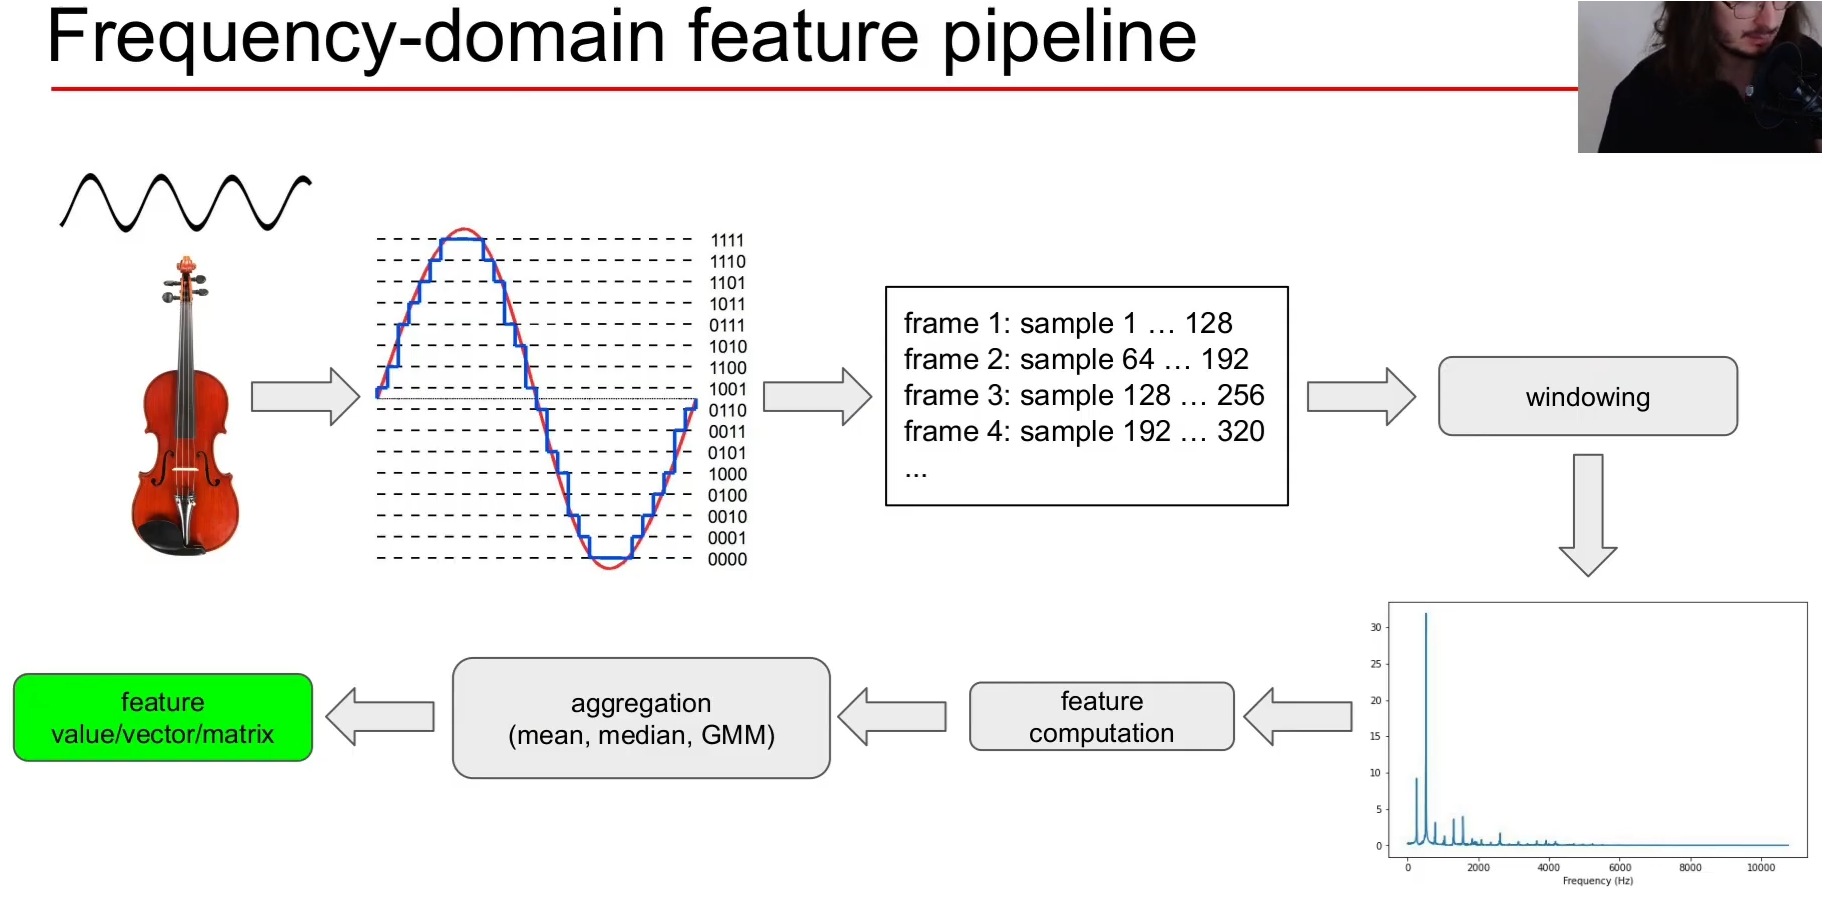

---

## 📚 Summary

### Key Concepts

1. **Non-Stationary Signals**: Audio properties change over time
2. **Framing**: Break signal into small chunks (frames)
3. **Spectral Leakage**: Discontinuities create fake frequencies
4. **Windowing**: Smooth tapering reduces leakage
5. **Hop Length**: Overlapping frames prevent data loss

### Best Practices

| Parameter | Recommended Value | Notes |
|-----------|------------------|-------|
| **Frame Size (n_fft)** | 2048 @ 22050 Hz | ~93 ms, good balance |
| **Hop Length** | n_fft / 2 | 50% overlap (standard) |
| **Window** | 'hann' | Best general-purpose choice |
| **Sample Rate** | 22050 Hz | Standard for ML applications |

### Trade-offs

- **Larger frames**: ↑ Frequency resolution, ↓ Time resolution
- **Smaller frames**: ↓ Frequency resolution, ↑ Time resolution
- **More overlap**: ↑ Quality, ↑ Computation time

### Next Steps

- Explore Mel-spectrograms (perceptually weighted)
- Learn about MFCCs (Mel-Frequency Cepstral Coefficients)
- Apply to real audio files
- Build ML models using these features

---

**Congratulations!** You now understand the fundamental concepts of audio signal processing for machine learning. 🎉